In [1]:
%matplotlib inline
from __future__ import print_function
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.dates as mdates
import matplotlib.cm as mcm
import matplotlib.colors as mcls
import matplotlib.colorbar as mcb
from matplotlib.ticker import AutoMinorLocator,MultipleLocator,ScalarFormatter
from matplotlib.ticker import FixedLocator,FixedFormatter,FuncFormatter,FormatStrFormatter
from mpl_toolkits.axes_grid.inset_locator import inset_axes,InsetPosition,mark_inset
import sys
import numpy as np
from scipy import interpolate
from scipy.ndimage import filters
from scipy.integrate import cumtrapz
import datetime as dt
from astropy.io import fits
import astropy.coordinates as coord
import astropy.units as u
import ephem
import pandas as pd
from barak import absorb
from array import array
import re
import resource
resource.setrlimit(resource.RLIMIT_NOFILE,(5000,-1))

In [2]:
# Set up for plotting
bfsize=22
plt.rc('font',family='serif',serif='cm10')
plt.rc('text',usetex=True)
plt.rcParams['figure.figsize'] = (8,5.5)
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['axes.labelsize'] = bfsize
plt.rcParams['axes.labelpad'] = 1.0
plt.rcParams['axes.labelweight'] = 540 # 400 is normal, 700 is bold
plt.rcParams['xtick.major.width'] = 1.4
plt.rcParams['ytick.major.width'] = 1.4
plt.rcParams['xtick.major.size'] = 0.3*bfsize
plt.rcParams['ytick.major.size'] = 0.3*bfsize
plt.rcParams['xtick.minor.width'] = 1.0
plt.rcParams['ytick.minor.width'] = 1.0
plt.rcParams['xtick.minor.size'] = 0.13*bfsize
plt.rcParams['ytick.minor.size'] = 0.13*bfsize
plt.rcParams['xtick.labelsize'] = 0.8*bfsize
plt.rcParams['ytick.labelsize'] = 0.8*bfsize
plt.rcParams['xtick.major.pad'] = 0.155*bfsize
plt.rcParams['ytick.major.pad'] = 0.155*bfsize
plt.rcParams['xtick.minor.pad'] = 0.155*bfsize
plt.rcParams['ytick.minor.pad'] = 0.155*bfsize
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.top'] = 'True'
plt.rcParams['ytick.right'] = 'True'
plt.rcParams['legend.numpoints'] = 1
plt.rcParams['legend.scatterpoints'] = 1
plt.rcParams['legend.fancybox'] = 'True'
plt.rcParams['legend.fontsize'] = 0.9*bfsize
plt.rcParams['legend.labelspacing'] = 0.25
plt.rcParams['legend.handletextpad'] = 0.35
plt.rcParams['legend.borderpad'] = 0.25
plt.rcParams['legend.borderaxespad'] = 0.6
plt.rcParams['legend.columnspacing'] = 0.5
plt.rcParams['legend.frameon'] = 'False'
plt.rcParams['legend.edgecolor'] = 'black'
plt.rcParams['text.latex.preamble']=[r'\usepackage{txfonts}']
#plt.rcParams['text.latex.preamble']=[r'\usepackage{newtxtext,newtxmath}']
#plt.rcParams['text.latex.preamble']=[r'\usepackage[T1]{fontenc}']

In [3]:
# Function to read in spectrum, header and table extension information from a DR1 UVES_popler FITS file
def rUVESpoplerFITS(FITSfile):
    with fits.open(FITSfile) as hdulist:
        h0,h1,h2,h3=hdulist[0].header,hdulist[1].header,hdulist[2].header,hdulist[3].header
        d0,d1,d2,d3=hdulist[0].data,hdulist[1].data,hdulist[2].data,hdulist[3].data
        n=d0.shape[-1]
        wl=(np.arange(n,dtype=float)+1-h0['CRPIX1'])*h0['CD1_1']+h0['CRVAL1']
        if (h0['DC-FLAG']==1):
            lw=wl
            wl=np.power(10.0,lw)
        else:
            lw=np.log10(wl)
        nf,ne,co,st,cs,npix=d0[0],d0[1],d0[3],d0[4].astype(int),d0[8],d0[6]
    return {'wl':wl,'lw':lw,'nf':nf,'ne':ne,'co':co,'st':st,'cs':cs,'npix':npix,'h0':h0,'h1':h1,'h2':h2,'h3':h3,'d1':d1,'d2':d2,'d3':d3}

# Function to read in clipped mean compisite DR1 spectrum and header
def rDR1CompositeFITS(FITSfile):
    with fits.open(FITSfile) as hdulist:
        h0=hdulist[0].header
        d0=hdulist[0].data
        n=d0.shape[-1]
        wl=(np.arange(n,dtype=float)+1-h0['CRPIX1'])*h0['CD1_1']+h0['CRVAL1']
        if (h0['DC-FLAG']==1):
            lw=wl
            wl=np.power(10.0,lw)
        else:
            lw=np.log10(wl)
        nf,ne,co,st,cs=d0[0],d0[1],d0[3],d0[4].astype(int),d0[8]
    return {'wl':wl,'lw':lw,'nf':nf,'ne':ne,'co':co,'st':st,'cs':cs,'h0':h0}

# Hard coding the path to the FITS file parent directory here.
# Each FITS file should sit within a subdirectory of this, named by its Name_Adopt name from the DR1 catalogue
UVESdir="/Users/mmurphy/data0/UVES"

# Function to read in DR1 list of quasar FITS files and gather relevant information from their readers.
# dfDR1 is a Pandas dataframe created by reading the DR1 csv catalogue
def rDR1spectra(dfDR1):
    spec=[{} for x in range(len(dfDR1))]
    nwavcal=0
    for i in range(0,len(dfDR1),1):
        # Only deal with quasars for which a final spectrum was produced
        if (re.search('[345]',dfDR1.Spec_status[i])) is None:
            FITSfile=UVESdir+"/"+dfDR1.Name_Adopt[i]+"/"+dfDR1.Name_Adopt[i]+".fits"
            s=rUVESpoplerFITS(FITSfile)
            spec[i]['Name']=dfDR1.Name_Adopt[i]
            # Create dictionary of exposure information for each spectrum
            spec[i]['Exp']={}
            # Record UT observation dates
            spec[i]['Exp']['UTDate']=s['d3']['UTDate']
            # Record binnings
            spec[i]['Exp']['Binning']=s['d3']['Binning']
            # Record settings
            spec[i]['Exp']['Setting']=s['d3']['CenWav']
            # Record slit widths
            spec[i]['Exp']['SlitWidth']=s['d3']['SlitWidth']
            # Record wavelength calibration redidual RMSs
            spec[i]['Exp']['WavcalRMS']=s['d3']['WavcalRMS']
            nwavcal+=len(spec[i]['Exp']['WavcalRMS'])
            # Record the CNR and SNR chunk-wise spectra
            spec[i]['Coarse']={}
            spec[i]['Coarse']['wl']=s['d1']['Wavelength']
            spec[i]['Coarse']['CNR']=s['d1']['CNRmed']
            spec[i]['Coarse']['SNR']=s['d1']['SNRmed']
    print(nwavcal)
    return spec

# Spectrum plot for a single QSO and any DLAs in its sight-line. Input spectrum, s, is a dictionary of the form
# {Name:QSO name, zem:emission redsfhit, wcstart:Start of wavelength coverage, wl:wavelength, nf:norm.bflux,
# ne:norm.berror}.
# Input DLA information, dla, is a dictionary of lists (one element per DLA) of the form
# {zabs:Absorption redshifts, logNHI:Log10 of neutral hydrogen column densities,
#  e_logNHI:1-sigma uncertainties in logNHI, annot:Annotation to include in DLA list in title of plot}
def DLAplot(s,dla):
    # Use Barak package to compute Lyman series absorption.
    # Assumpions: b=20.0km/s, vFWHM=6.0km/s
    trans,ticks={},{}
    mod=np.ones_like(s['wl'])
    for j in range(0,len(dla['zabs']),1):
        trans[j],ticks[j]=absorb.calc_DLA_trans(s['wl'],dla['zabs'][j],6.0,logN=dla['logNHI'][j],bHI=20.0)
        mod=mod*trans[j]
    LyaEmi=(1.0+s['zem'])*1215.6701
    ws,we=s['wcstart'],(1.0+10000.0/299792.458)*LyaEmi
    step=1.05
    nax=np.ceil(np.log10(we/ws)/np.log10(step)).astype(int)
    wls=np.power(step,range(0,nax))*ws
    wle=np.power(step,range(1,nax+1))*ws
    fig=plt.figure(figsize=(40.0,nax*12.0))
    ax={}
    for i in np.arange(0,len(wls),1):
        ax[i]=plt.subplot2grid((len(wls),1),(i,0),rowspan=1,colspan=1)
        filt=[(s['wl']>=wls[i]) & (s['wl']<wle[i])]
        x,y,e,m=s['wl'][filt],s['nf'][filt],s['ne'][filt],mod[filt]
        smooth=filters.gaussian_filter1d(y,4.0)
        n=len(x)
        mede=np.median(e)
        ymax=(1.0+max(0.11,1.5*mede)) if (n>0) else 1.0
        ymin=min(-0.04,-1.5*mede)*ymax
        yrng=ymax-ymin
        ax[i].hlines([0.0,1.0],wls[i],wle[i],colors=['#99FFFF','#99FFFF'],linestyles=[':','--'],
                     linewidths=[1.5,1.5],zorder=1)
        ax[i].step(x,y,where='mid',lw=0.5,color='black',alpha=0.2,rasterized=True)
        ax[i].plot(x,smooth,ls='-',lw=2.0,color='black',alpha=0.8,rasterized=True)
        ax[i].plot(x,m,ls='-',lw=2.0,color='green',alpha=0.8,rasterized=True)
        ax[i].plot(x,e,ls='-',lw=0.50,color='red',alpha=0.3,rasterized=True)
        dlatitle=""
        for j in range(0,len(dla['zabs']),1):
            dlatitle=dlatitle+"["+('%.3f' % dla['zabs'][j])+","+('%.2f' % dla['logNHI'][j])+","+dla['annot']+"],"
            t=ticks[j][(ticks[j].wa>=wls[i]) & (ticks[j].wa<wle[i])]
            for k in range(0,len(t),1):
                ax[i].vlines(t.wa[k],-0.02,0.85,colors='blue',linestyles='--',linewidths=4.0,zorder=100)
                lab=t.name[k]+"["+str(t.ind[k])+"] "+('%.1f' % t.wa0[k])+" z="+('%.3f' % t.z[k])
                ax[i].text(t.wa[k],0.86,lab,color='blue',rotation=90,ha='center',va='bottom',fontsize=0.8*bfsize)
        ax[i].set_xlim(wls[i],wle[i])
        ax[i].set_ylim(ymin,ymax)
        if (i==0):
            plt.title(r'%s, $z_{\rm em}=%.3lf$, [$z_{\rm DLA},\log(N\textsc{h\small{\,i}})]=%s$' % (s['Name'],s['zem'],dlatitle[:-1]),loc='center',
                      fontsize=bfsize)
        if (i==len(wls)-1):
            ax[i].set_xlabel(r'Wavelength [\AA]')
    fig.subplots_adjust(left=0.01,right=0.99,bottom=0.02,top=0.98,wspace=0.0,hspace=0.05)
    return

def fNHI_Gamma(kg,alphag,Ng,N):
    ratio=N/Ng
    return kg*np.power(ratio,alphag)*np.exp(-ratio)

In [4]:
# Read in DR1 quasar master information file
DR1QSOs="DR1_quasars_master.csv"
dDR1QSOs=pd.read_csv(DR1QSOs)

In [5]:
# Read in DR1 quasar spectra and/or headers
spec=rDR1spectra(dDR1QSOs)

8764


# Sky position distribution of DR1 quasars with final spectra

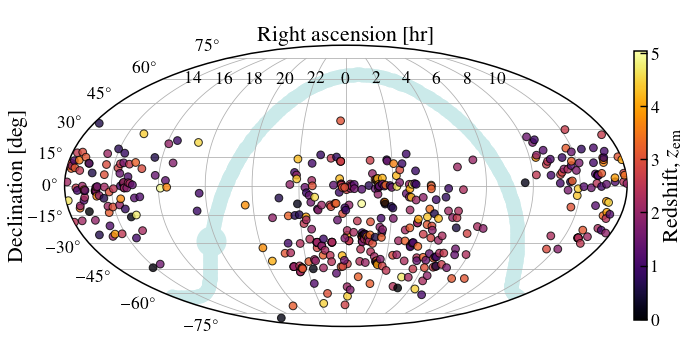

In [10]:
fig=plt.figure(figsize=(12,9.0))
ax1=plt.subplot2grid((1,1),(0,0),rowspan=1,colspan=1,projection="mollweide")

# Convert adopted RA and Dec. into proper coordinate objects
ra=coord.Angle(dDR1QSOs.RA_Adopt,unit=u.hour).wrap_at(180*u.degree)
dec=coord.Angle(dDR1QSOs.Dec_Adopt,unit=u.degree)

# Only deal with quasars with DR1 spectra available (Spec_status=0–2)
filt=np.array([(re.search('[345]',i) is None) for i in dDR1QSOs.Spec_status])

# Colour the points according to the redshift
#cmap=mcm.get_cmap('jet')
#cmap=mcm.get_cmap('viridis')
cmap=mcm.get_cmap('inferno')
zem=dDR1QSOs.zem_Adopt[filt].values
normalize=mcls.Normalize(vmin=min(zem)-0.03,vmax=max(zem))
colors=[cmap(normalize(value)) for value in zem]

# Plot the quasar positions
ax1.scatter(ra.radian[filt],dec.radian[filt],marker='o',s=60.0,c=colors,alpha=0.8,edgecolors='black',zorder=100)

# Custom x tick labels off the equator
#ax1.set_xticklabels(['14','16','18','20','22','0','2','4','6','8','10'])
ax1.set_xticklabels("")
RAlab=[14,16,18,20,22,0,2,4,6,8,10]
for x in RAlab:
    RAcoord=coord.Angle(x,unit=u.hour).wrap_at(180*u.degree)
    ax1.annotate(r'%s' % x,xy=(RAcoord.radian,1.0472),color='black',ha='center',va='center',fontsize=0.8*bfsize)

# Draw the galactic plane and bulge
lon_array=np.arange(0,360,1)
lat=0.0
eq_array=np.zeros((360,2))
for lon in lon_array:
    ga=ephem.Galactic(np.radians(lon),np.radians(lat))
    eq=ephem.Equatorial(ga)
    eq_array[lon]=np.degrees(eq.get())
gRA,gDec=eq_array[:,0],eq_array[:,1]
gRA=coord.Angle(gRA,unit=u.degree).wrap_at(180*u.degree)
gDec=coord.Angle(gDec,unit=u.degree)
ax1.scatter(gRA.radian,gDec.radian,marker='o',s=200.0,c="#CBEAEA",linewidth=0,rasterized=True)
ax1.scatter(gRA.radian[0],gDec.radian[0],marker='o',s=900.0,c="#CBEAEA",linewidth=0,rasterized=True)
ax1.grid(True)
ax1.set_xlabel("Right ascension [hr]",fontsize=bfsize,labelpad=5)
ax1.xaxis.set_label_position('top')
ax1.set_ylabel("Declination [deg]",fontsize=bfsize)
handles,labels=ax1.get_legend_handles_labels()
# Reverse the order of legend labels
leg=ax1.legend(handles[::-1],labels[::-1],loc=1,ncol=3,handlelength=1.0,frameon=False,bbox_to_anchor=(0.95,1.18))

# Make redshift colour bar
cax,_=mcb.make_axes(ax1,shrink=0.55,pad=0.01)#,orientation='horizontal')
cbar=mcb.ColorbarBase(cax,cmap=cmap,norm=normalize,alpha=1.0)#,orientation='horizontal')
cbar.set_label(r'Redshift, $z_{\rm em}$',fontsize=bfsize,labelpad=6)
#plt.colorbar(sc)

# Export to PDF
#plt.savefig('DR1_skymap.pdf',bbox_inches='tight',pad_inches=0.02)

# Redshift distribution of DR1 quasars (with final spectra)

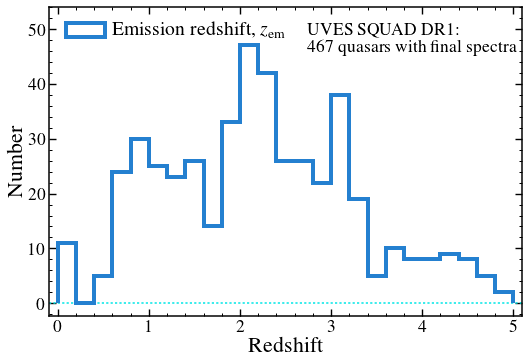

In [9]:
fig=plt.figure(figsize=(7.0,5.0))
ax1=plt.subplot2grid((1,1),(0,0),rowspan=1,colspan=1)

# Good colour matches for the colourblind
myc={'blue':'#2480D0','cyan':'#00E6E6','orange':'#EC9800'}

## Plot quasar emission redshift histogram for those with DR1 spectra available (Spec_status=0–2)
filt=np.array([(re.search('[345]',i) is None) for i in dDR1QSOs.Spec_status])
zem=dDR1QSOs.zem_Adopt[filt]
xmin,xmax=np.amin(zem),np.amax(zem)
binwid=0.2
bins=np.arange(xmin,xmax,binwid)
n,e,_=ax1.hist(zem,bins,align='mid',histtype='step',lw=4.0,ls='-',color=myc['blue'],alpha=1.0,
                label=r'Emission redshift, $z_{\rm em}$',zorder=100)
xmin,xmax=e[0]-0.5*binwid,e[-1]+0.5*binwid
xrng=xmax-xmin
ymax=max(n)
ymin,ymax=-0.05*ymax,1.15*ymax
yrng=ymax-ymin
ax1.hlines([0.0],xmin,xmax,colors=myc['cyan'],linestyles=':',linewidths=1.5)
ax1.set_xlabel(r'Redshift',ha='center',fontsize=bfsize)
ax1.set_ylabel(r'Number',ha='center',va='bottom',fontsize=bfsize)
#ax1.annotate('UVES SQUAD DR1:\n475 quasars\n(467 with final spectra)',xy=(0.6,0.95),
#             xycoords='axes fraction',color='black',ha='left',va='top',fontsize=0.8*bfsize)
ax1.annotate('UVES SQUAD DR1:\n467 quasars with final spectra',xy=(0.545,0.95),
             xycoords='axes fraction',color='black',ha='left',va='top',fontsize=0.8*bfsize)

ax1.set_xlim(xmin,xmax)
ax1.set_ylim(ymin,ymax)
ax1.yaxis.set_minor_locator(AutoMinorLocator(5))

# Legend
handles1,labels1=ax1.get_legend_handles_labels()
leg=ax1.legend(handles1,labels1,loc='upper left')
#leg.get_frame().set_alpha(0.6)

plt.minorticks_on()
fig.subplots_adjust(left=0.05,right=0.99,bottom=0.13,top=0.99,wspace=0.0,hspace=0.0)
# Export to PDF
#plt.savefig('DR1_zemdist.pdf',bbox_inches='tight',pad_inches=0.05)

# Ly-$\alpha$ forest, OVI, CIV, SiIV and MgII coverage

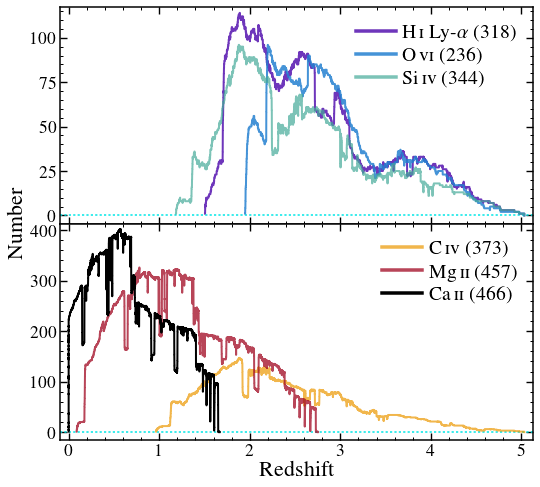

In [14]:
fig=plt.figure(figsize=(7.0,7.0))

myc={'violet':'#6E36BB','blue':'#2480D0','cyan':'#00E6E6','green':'#44AA99',
     'orange':'#EC9800','red':'#A00620','black':'#000000'}
colours=[myc['violet'],myc['blue'],myc['green'],myc['orange'],myc['red'],myc['black']]

## Calculate coverage for different transitions, noting some different restrictions on detecting each one
# Only deal with main transition of each species (e.g. MgII2796, not 2803)
ion=[r'H{\sc \,i} Ly-$\alpha$',r'O{\sc \,vi}',r'Si{\sc \,iv}',r'C{\sc \,iv}',r'Mg{\sc \,ii}',r'Ca{\sc \,ii}']
wl0=[1215.6701,1031.9261,1393.7601770,1548.2049,2796.35379,3934.7745890]
ntran=len(wl0)

# Construct arrays of starting and ending redshifts for Lya coverage
z=[array('d'),array('d'),array('d'),array('d'),array('d'),array('d')]
c=[array('d'),array('d'),array('d'),array('d'),array('d'),array('d')]
ncovered=np.array([0,0,0,0,0,0])
for i in range(0,len(dDR1QSOs)):
    covered=np.array([0,0,0,0,0,0])
    if (re.search('[345]',dDR1QSOs.Spec_status[i]) is None):
        Lya=wl0[0]*(1.0+dDR1QSOs.zem_Adopt[i])
        Lyb=1025.7223*(1.0+dDR1QSOs.zem_Adopt[i])
        for wlcov in dDR1QSOs.WavCoverage[i].split(','):
            ws=float(wlcov.split('-')[0])
            we=float(wlcov.split('-')[1])
            for j in range(0,ntran):
                zs=max(0.0,ws/wl0[j]-1.0)
                ze=max(0.0,we/wl0[j]-1.0)
                if (zs<=dDR1QSOs.zem_Adopt[i]):
                    if ((j==0) & (we>Lyb)):
                        # For Lya forest, only sample down to Lyb
                        covered[j]=1
                        z[j].append(max(zs,Lyb/wl0[j]-1.0))
                        c[j].append(1.0)
                        z[j].append(min(ze,dDR1QSOs.zem_Adopt[i]))
                        c[j].append(-1.0)
                    elif (j==1):
                        # For OVI, just allow all redshifts up to emission redshift
                        covered[j]=1
                        z[j].append(zs)
                        c[j].append(1.0)
                        z[j].append(min(ze,dDR1QSOs.zem_Adopt[i]))
                        c[j].append(-1.0)
                    elif ((j>=2) & (we>Lya)):
                        # For SiIV, CIV, MgII and CaII only sample down to Lya
                        covered[j]=1
                        z[j].append(max(zs,Lya/wl0[j]-1.0))
                        c[j].append(1.0)
                        z[j].append(min(ze,dDR1QSOs.zem_Adopt[i]))
                        c[j].append(-1.0)
    ncovered+=covered   

# Form the coverage functions by sorting the arrays together
ztran={}
covfunc={}
for i in range(0,ntran):
    zed=np.array(z[i])
    s=zed.argsort()
    ztran[i]=zed[s]
    covfunc[i]=np.cumsum(np.array(c[i])[s])

## Plot the results
# Upper panel has Lya, OVI and SiIV
ax1=plt.subplot2grid((2,1),(0,0),rowspan=1,colspan=1)
filt=np.array([(re.search('[345]',i) is None) for i in dDR1QSOs.Spec_status])
zem=dDR1QSOs.zem_Adopt[filt]
xmin,xmax=np.amin(zem)-0.1,np.amax(zem)+0.1
xrng=xmax-xmin
ymax=max([np.amax(covfunc[i]) for i in range(0,3)])
ymin,ymax=-0.04*ymax,1.03*ymax
yrng=ymax-ymin
ax1.hlines([0.0],xmin,xmax,colors=myc['cyan'],linestyles=':',linewidths=1.5)
for i in range(0,3):
    ax1.step(ztran[i],covfunc[i],where='post',lw=2.0,color=colours[i],alpha=1.0-i*0.15,
         label=ion[i]+' (%d)' % ncovered[i])#,rasterized=True)
ax1.xaxis.set_minor_locator(AutoMinorLocator(5))
ax1.yaxis.set_minor_locator(AutoMinorLocator(5))
ax1.set_xlim(xmin,xmax)
ax1.set_ylim(ymin,ymax)

# Lower panel has CIV, MgII and CaII
ax2=plt.subplot2grid((2,1),(1,0),rowspan=1,colspan=1)
xmin,xmax=np.amin(zem)-0.1,np.amax(zem)+0.1
xrng=xmax-xmin
ymax=max([np.amax(covfunc[i]) for i in range(3,ntran)])
ymin,ymax=-0.04*ymax,1.03*ymax
yrng=ymax-ymin
ax2.hlines([0.0],xmin,xmax,colors=myc['cyan'],linestyles=':',linewidths=1.5)
for i in range(3,ntran):
    alpha=0.7 if (i==3) else 1.0-(ntran-i-1)*0.25
    ax2.step(ztran[i],covfunc[i],where='post',lw=2.0,color=colours[i],alpha=alpha,
         label=ion[i]+' (%d)' % ncovered[i])#,rasterized=True)
ax2.set_xlabel(r'Redshift',ha='center',fontsize=bfsize)
ax2.annotate(r'Number',xy=(-0.09,1.0),xycoords='axes fraction',color='black',
             ha='center',va='center',rotation=90,fontsize=bfsize)
ax2.xaxis.set_minor_locator(AutoMinorLocator(5))
ax2.yaxis.set_minor_locator(AutoMinorLocator(5))
ax2.set_xlim(xmin,xmax)
ax2.set_ylim(ymin,ymax)

# Legends
handles1,labels1=ax1.get_legend_handles_labels()
handles2,labels2=ax2.get_legend_handles_labels()
leg=ax1.legend(handles1,labels1,loc=1)
for legobj in leg.legendHandles:
    legobj.set_linewidth(3.5)
leg=ax2.legend(handles2,labels2,loc=1)
for legobj in leg.legendHandles:
    legobj.set_linewidth(3.5)
#leg.get_frame().set_alpha(0.6)

plt.minorticks_on()
fig.subplots_adjust(left=0.05,right=0.99,bottom=0.13,top=0.99,wspace=0.0,hspace=0.0)
# Export to PDF
#plt.savefig('DR1_trancoverage.pdf',bbox_inches='tight',pad_inches=0.05)

# $g(z)$ for Ly-$\alpha$ forest, CIV, SiIV and MgII

In [15]:
## Calculate coverage for different transitions, noting some different restrictions on detecting each one
# Only deal with main transition of each species (e.g. MgII2796, not 2803)
ion=[r'H{\sc \,i} Ly-$\alpha$',r'Si{\sc \,iv}',r'C{\sc \,iv}',r'Mg{\sc \,ii}',r'Ca{\sc \,ii}']
wl0=[[1215.6701,1215.6701],
     [1393.760177,1402.772912],
     [1548.20490,1550.77845],
     [2796.353790,2803.530982],
     [3934.7745890,3969.5896520]]
ntran=len(wl0)
cnrthresh=[[2,5,10,20],
           [5,10,20,40],
           [5,10,20,40],
           [5,10,20,40],
           [5,10,20,40]]
ncnr=len(cnrthresh[0])
tell=np.array([[6867,6945],
      [7595,7707],
      [7163,7302],
      [8130,8360],
      [8935,11000]])
ntell=len(tell)

# Define emission-line proximity velocity threshold
dvprox=3000.0

# Define z limits and step size
zmin,zmax,zstep=0.0,5.1,0.002

# Create redshift and gz arrays
z=np.arange(zmin,zmax,zstep)
gz=np.zeros((ntran,ncnr,len(z)))

for i in range(0,len(dDR1QSOs)):
    if (re.search('[345]',dDR1QSOs.Spec_status[i]) is None):
        # Make a couple of simple lists with start and end of each wavelength coverage section
        ws=[float(ws.split('-')[0]) for ws in dDR1QSOs.WavCoverage[i].split(',')]
        we=[float(we.split('-')[1]) for we in dDR1QSOs.WavCoverage[i].split(',')]
        for t in range(0,ntran):
            for j in range(0,len(z)):
                w1=wl0[t][0]*(1.0+z[j])
                w2=wl0[t][1]*(1.0+z[j])
                covered,notprox,nottell=0,0,1
                # First check whether both transitions are covered
                if ((w1>=ws[0]) & (w2<=we[-1])):
                    c1=next(x[0] for x in enumerate(we) if x[1]>=w1)
                    if (ws[c1]<=w1):
                        c2=next(x[0] for x in enumerate(we) if x[1]>=w2)
                        if (ws[c2]<=w2): covered=1
                # Determine whether either transition falls in strong telluric regions
                if (covered==1):
                    if ((w1>=tell[:,0][w1<=tell[:,1]][0]) | (w2>=tell[:,0][w2<=tell[:,1]][0])):
                        nottell=0
                # Determine whether redshift is within proximity zone of emission redshift or
                # too near Lyb (for Lya) or Lya (for metals)
                if ((covered==1) & (nottell==1)):
                    dvem=(dDR1QSOs.zem_Adopt[i]-z[j])/(1.0+dDR1QSOs.zem_Adopt[i])*299792.458
                    Lyem=wl0[0][0] if (t>0) else 1025.7223
                    zLyem=Lyem*(1.0+dDR1QSOs.zem_Adopt[i])/wl0[t][0]-1.0
                    dvLyem=(z[j]-zLyem)/(1.0+zLyem)*299792.458
                    if ((dvem>dvprox) & (dvLyem>dvprox)): notprox=1
                # Find the median CNR in the coarse spectrum bin closest to each transition
                if ((covered==1) & (nottell==1) & (notprox==1)):
                    wl=spec[i]['Coarse']['wl']
                    # Convert CNR per pix to CNR per 2.5-km/s pix
                    cnrmed=spec[i]['Coarse']['CNR']*np.sqrt(2.5/dDR1QSOs.Dispersion[i])
                    wls,wle=wl[cnrmed>0.0][0],wl[cnrmed>0.0][-1]
                    if ((w1>=wls) & (w2<=wle)):
                        cnr1,cnr2=cnrmed[wl>=w1][0],cnrmed[wl>=w2][0]
                        # Add unity to g(z) array if each CNR threshold is exceeded
                        for cnr in range(0,ncnr):
                            if ((cnr1>cnrthresh[t][cnr]) & (cnr2>cnrthresh[t][cnr])):
                                gz[t][cnr][j]+=1.0


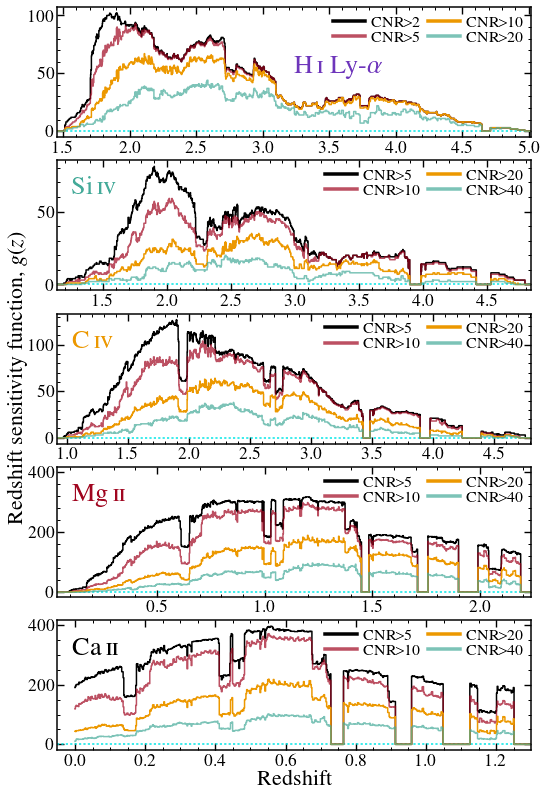

In [21]:
# Plot the g(z) results above
fig=plt.figure(figsize=(7.0,12.0))

myc={'violet':'#6E36BB','blue':'#2480D0','cyan':'#00E6E6','green':'#44AA99',
     'orange':'#EC9800','red':'#A00620','black':'#000000'}
colours=[myc['violet'],myc['green'],myc['orange'],myc['red'],myc['black']]

i=0
ax={}
for i in range(0,ntran):
    ax[i]=plt.subplot2grid((ntran,1),(i,0),rowspan=1,colspan=1)
    xmin=z[gz[i][0]>0.0][0]-0.05
    xmax=z[gz[i][0]>0.0][-1]+0.05
    xrng=xmax-xmin
    ymax=max(gz[i][0])
    ymin,ymax=-0.05*ymax,1.05*ymax
    if (i==3): ymax=1.25*ymax
    yrng=ymax-ymin
    ax[i].hlines([0.0],xmin,xmax,colors=myc['cyan'],linestyles=':',linewidths=1.5)
    for j in range(0,ncnr):
        alpha=1.0 if ((j==0) | (j==2)) else 0.7
        ax[i].step(z,gz[i][j],where='mid',lw=1.5,linestyle='-',color=colours[-j-1],alpha=alpha,
                   label=r'${\rm CNR}\!\!>\!\!%.0f$' % cnrthresh[i][j])#,rasterized=True)
    if (i==ntran-1): ax[i].set_xlabel(r'Redshift',ha='center',fontsize=bfsize)
    if (i==2): ax[i].set_ylabel(r'Redshift sensitivity function, $g(z)$',ha='center',va='bottom',fontsize=bfsize)
    loc=(0.50,0.54) if (i==0) else (0.03,0.78)
    ax[i].annotate(ion[i],xy=loc,xycoords='axes fraction',color=colours[i],ha='left',va='center',fontsize=1.2*bfsize)
    ax[i].xaxis.set_minor_locator(AutoMinorLocator(5))
    ax[i].yaxis.set_minor_locator(AutoMinorLocator(5))
    ax[i].set_xlim(xmin,xmax)
    ax[i].set_ylim(ymin,ymax)    
    # Legend
    handles,labels=ax[i].get_legend_handles_labels()
    leg=ax[i].legend(handles,labels,fontsize=0.73*bfsize,labelspacing=0.03,borderpad=0.0,
                     borderaxespad=0.5,loc=1,ncol=2)
    for legobj in leg.legendHandles:
        legobj.set_linewidth(3.5)

plt.minorticks_on()
fig.subplots_adjust(left=0.05,right=0.99,bottom=0.13,top=0.99,wspace=0.0,hspace=0.18)
# Export to PDF
plt.savefig('DR1_gz.pdf',bbox_inches='tight',pad_inches=0.05)

# Observed and rest-frame wavelength coverage maps

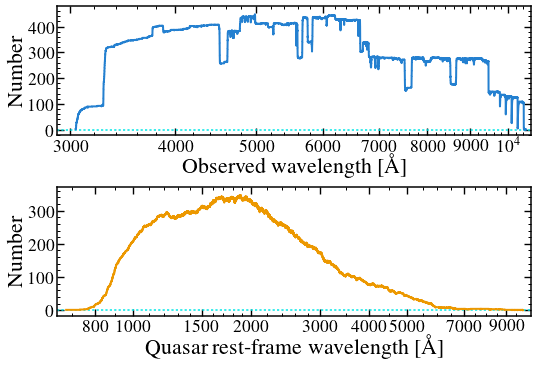

In [10]:
fig=plt.figure(figsize=(7.0,5.0))

# Good colour matches for the colourblind
myc={'blue':'#2480D0','cyan':'#00E6E6','orange':'#EC9800'}

# Construct arrays of starting and ending wavelengths for coverage arrays
w=[array('d')]*2
c=[array('d')]*2
for i in range(0,len(dDR1QSOs)):
    if (re.search('[345]',dDR1QSOs.Spec_status[i]) is None):
        for wlcov in dDR1QSOs.WavCoverage[i].split(','):
            ws=float(wlcov.split('-')[0])
            we=float(wlcov.split('-')[1])
            w[0].append(ws)
            c[0].append(1.0)
            w[0].append(we)
            c[0].append(-1.0)
            w[1].append(ws/(dDR1QSOs.zem_Adopt[i]+1.0))
            c[1].append(1.0)
            w[1].append(we/(dDR1QSOs.zem_Adopt[i]+1.0))
            c[1].append(-1.0)

# Form the coverage functions by sorting the arrays together
wfinal={}
covfunc={}
for i in range(0,2):
    wl=np.array(w[i])
    s=wl.argsort()
    wfinal[i]=wl[s]
    covfunc[i]=np.cumsum(np.array(c[i])[s])

## Plot observed wavelength coverage function
ax1=plt.subplot2grid((2,1),(0,0),rowspan=1,colspan=1)
xmin,xmax=np.amin(wfinal[0]),np.amax(wfinal[0])
xrng=xmax-xmin
xmin,xmax=xmin-0.02*xrng,xmax+0.02*xrng
xrng=xmax-xmin
ymax=np.amax(covfunc[0])
ymin,ymax=-0.05*ymax,1.07*ymax
yrng=ymax-ymin
ax1.hlines([0.0],xmin,xmax,colors=myc['cyan'],linestyles=':',linewidths=1.5)
ax1.step(wfinal[0],covfunc[0],where='post',lw=2.0,color=myc['blue'],alpha=1.0,
         label=r'Observed wavelength')#,rasterized=True)
ax1.set_xlabel(r'Observed wavelength [\AA]',ha='center',fontsize=bfsize,labelpad=-1.5)
ax1.set_ylabel(r'Number',ha='center',va='bottom',fontsize=bfsize)
ax1.set_xscale('log')
xticksmajor=[3000,4000,5000,6000,7000,8000,9000,10000]
xticksmajorf=[r'3000',r'4000',r'5000',r'6000',r'7000',r'8000',r'9000',r'$10^4$']
xticksminor=[3200,3400,3600,3800,4200,4400,4600,4800,5200,5400,5600,5800,6200,6400,6600,6800,
            7200,7400,7600,7800,8200,8400,8600,8800,9200,9400,9600,9800,10200,10400]
xticksminorf=['']*30
ax1.xaxis.set_major_locator(FixedLocator(xticksmajor))
ax1.xaxis.set_major_formatter(FixedFormatter(xticksmajorf))
ax1.xaxis.set_minor_locator(FixedLocator(xticksminor))
ax1.xaxis.set_minor_formatter(FixedFormatter(xticksminorf))
ax1.yaxis.set_major_locator(MultipleLocator(100))
ax1.yaxis.set_minor_locator(AutoMinorLocator(5))
ax1.set_xlim(xmin,xmax)
ax1.set_ylim(ymin,ymax)

## Plot observed wavelength coverage function
ax2=plt.subplot2grid((2,1),(1,0),rowspan=1,colspan=1)
xmin,xmax=np.amin(wfinal[1]),np.amax(wfinal[1])
xmin,xmax=0.95*xmin,1.05*xmax
xrng=xmax-xmin
ymax=np.amax(covfunc[1])
ymin,ymax=-0.05*ymax,1.07*ymax
yrng=ymax-ymin
ax2.hlines([0.0],xmin,xmax,colors=myc['cyan'],linestyles=':',linewidths=1.5)
ax2.step(wfinal[1],covfunc[1],where='post',lw=2.0,color=myc['orange'],alpha=1.0,
         label=r'Quasar rest-frame wavelength')#,rasterized=True)
ax2.set_xlabel(r'Quasar rest-frame wavelength [\AA]',ha='center',fontsize=bfsize,labelpad=-1.5)
ax2.set_ylabel(r'Number',ha='center',va='bottom',fontsize=bfsize)
ax2.set_xscale('log')
xticksmajor=[800,1000,1500,2000,3000,4000,5000,7000,9000]
xticksminor=[700,900,1100,1200,1300,1400,1600,1700,1800,1900,2200,2400,2600,2800,
            3500,4500,5500,6000,6500,7500,8000,8500,9500]
xticksminorf=['']*23
ax2.set_xticks(xticksmajor)
ax2.xaxis.set_major_formatter(ScalarFormatter())
ax2.xaxis.set_minor_locator(FixedLocator(xticksminor))
ax2.xaxis.set_minor_formatter(FixedFormatter(xticksminorf))
ax2.yaxis.set_major_locator(MultipleLocator(100))
ax2.yaxis.set_minor_locator(AutoMinorLocator(5))
ax2.set_xlim(xmin,xmax)
ax2.set_ylim(ymin,ymax)

fig.subplots_adjust(left=0.05,right=0.99,bottom=0.13,top=0.99,wspace=0.0,hspace=0.40)
# Export to PDF
#plt.savefig('DR1_wlcoverage.pdf',bbox_inches='tight',pad_inches=0.05)

# CNR and SNR histograms in observed and rest-frame wavelength

3500 2.0 0.764347798717 151.706941729 7.65317808907
4500 15.0 1.48790684252 169.731918327 12.1800559035
5500 26.0 3.76708951001 341.628534092 19.5493835802
6500 28.0 5.10318444569 383.664852748 22.8072116741
7500 14.0 5.0811898752 270.216595517 19.8058852258


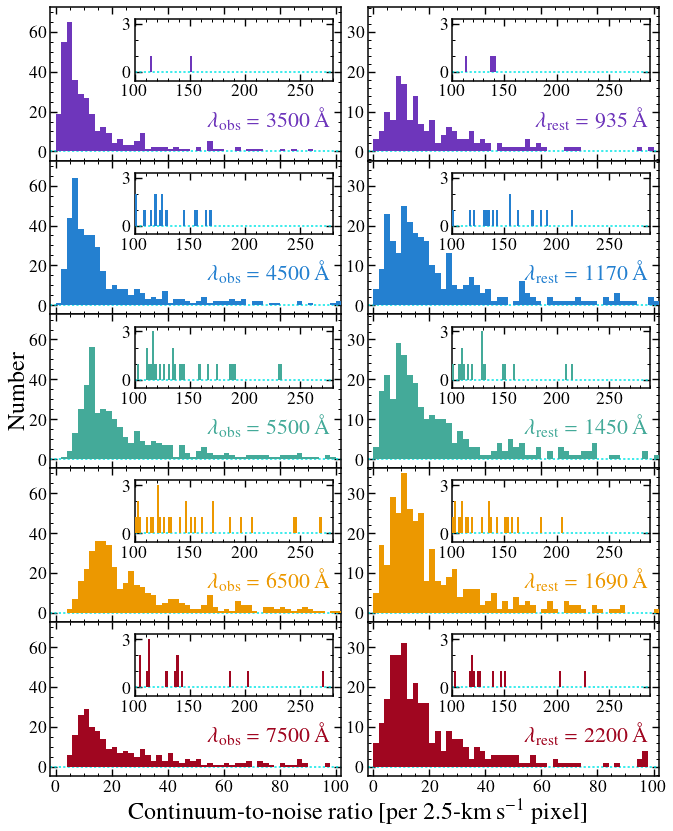

In [8]:
fig=plt.figure(figsize=(9.0,12.0))

# Good colour matches for the colourblind
myc={'violet':'#6E36BB','blue':'#2480D0','cyan':'#00E6E6','green':'#44AA99',
     'orange':'#EC9800','red':'#A00620','black':'#000000'}
colours=[myc['violet'],myc['blue'],myc['green'],myc['orange'],myc['red'],
         myc['violet'],myc['blue'],myc['green'],myc['orange'],myc['red']]

# Plot the continuum-to-noise ratio for specific observed wavelengths
nrows,ncols=5,2
bins=np.arange(0.0,290,2.0)
binwid=bins[1]-bins[0]
i=0
ax={}
axin={}
cnr=array('d')
for wl0 in [3500,4500,5500,6500,7500]:
    col=int(np.modf(i/nrows)[1])
    row=int(i-col*nrows)
    ax[wl0]=plt.subplot2grid((nrows,ncols),(row,col),rowspan=1,colspan=1)
    cnr=[]
    for j in range(0,len(dDR1QSOs)):
        if (re.search('[345]',dDR1QSOs.Spec_status[j])) is None:
            wl=spec[j]['Coarse']['wl']
            cnrmed=spec[j]['Coarse']['CNR']*np.sqrt(2.5/dDR1QSOs.Dispersion[j])
            wls,wle=wl[cnrmed!=0.0][0],wl[cnrmed!=0.0][-1]
            if ((wls<=wl0) & (wle>=wl0)):
                cnr.append(cnrmed[wl>=wl0][0]) if (cnrmed[wl>=wl0][0]>0.0) else -100.0
    n,e,_=ax[wl0].hist(cnr,bins,align='mid',histtype='stepfilled',lw=3.0,ls='-',color=colours[i],alpha=1.0,
                        label=r'%d' % wl0,zorder=100)
    print(wl0,np.sum(n[bins[0:-1]>=100.0]),np.amin(cnr),np.amax(cnr),np.median(cnr))
    xmin,xmax=-2.0,102.0
    xrng=xmax-xmin
    ymax=66.0
    ymin,ymax=-0.07*ymax,1.10*ymax
    yrng=ymax-ymin
    ax[wl0].hlines([0.0],xmin,xmax,colors=myc['cyan'],linestyles=':',linewidths=1.5)
    ax[wl0].set_xlim(xmin,xmax)
    ax[wl0].set_ylim(ymin,ymax)
    ax[wl0].xaxis.set_major_locator(MultipleLocator(20))
    ax[wl0].xaxis.set_minor_locator(AutoMinorLocator(4))
    ax[wl0].yaxis.set_major_locator(MultipleLocator(20))
    ax[wl0].yaxis.set_minor_locator(AutoMinorLocator(4))
    ax[wl0].annotate(r'$\lambda_{\rm obs}=%d$\,\AA' % wl0,xy=(0.96,0.25),xycoords='axes fraction',
                      color=colours[i],ha='right',va='center',fontsize=bfsize)
    if (row!=4):
        ax[wl0].axes.get_xaxis().set_ticklabels([])
    if ((col==0) & (row==4)):
        ax[wl0].annotate(r'Continuum-to-noise ratio [per 2.5-km\,s$^{-1}$ pixel]',
                          xy=(1.055,-0.23),xycoords='axes fraction',color='black',
                          ha='center',va='center',fontsize=1.1*bfsize)
    if ((col==0) & (row==2)):
        ax[wl0].annotate(r'Number',xy=(-0.11,0.5),xycoords='axes fraction',color='black',
                          ha='center',va='center',fontsize=1.1*bfsize,rotation='vertical')
    axin[wl0]=inset_axes(ax[wl0],width="45%",height="45%")
    axin[wl0].set_axes_locator(InsetPosition(ax[wl0],[0.29,0.52,0.68,0.40]))
    xmin,xmax=100,280
    xrng=xmax-xmin
    ymax=3.0
    ymin,ymax=-0.18*ymax,1.10*ymax
    yrng=ymax-ymin
    axin[wl0].hist(cnr,bins,align='mid',histtype='stepfilled',lw=3.0,ls='-',color=colours[i],alpha=1.0,zorder=100)
    axin[wl0].hlines([0.0],xmin,xmax,colors=myc['cyan'],linestyles=':',linewidths=1.5)
    axin[wl0].xaxis.set_major_locator(MultipleLocator(50))
    axin[wl0].xaxis.set_minor_locator(AutoMinorLocator(5))
    axin[wl0].yaxis.set_major_locator(MultipleLocator(3))
    axin[wl0].yaxis.set_minor_locator(AutoMinorLocator(3))
    axin[wl0].set_xlim(xmin,xmax)
    axin[wl0].set_ylim(ymin,ymax)
    i+=1

# Plot the continuum-to-noise ratio for specific rest-frame wavelengths
nrows,ncols=5,2
bins=np.arange(0.0,290,2.0)
binwid=bins[1]-bins[0]
i=5
ax={}
axin={}
cnr=array('d')
for wl0 in [935,1170,1450,1690,2200]:
    col=int(np.modf(i/nrows)[1])
    row=int(i-col*nrows)
    ax[wl0]=plt.subplot2grid((nrows,ncols),(row,col),rowspan=1,colspan=1)
    cnr=[]
    for j in range(0,len(dDR1QSOs)):
        if (re.search('[345]',dDR1QSOs.Spec_status[j])) is None:
            wl=spec[j]['Coarse']['wl']
            cnrmed=spec[j]['Coarse']['CNR']*np.sqrt(2.5/dDR1QSOs.Dispersion[j])
            wls,wle=wl[cnrmed!=0.0][0]/(1.0+dDR1QSOs.zem_Adopt[j]),wl[cnrmed!=0.0][-1]/(1.0+dDR1QSOs.zem_Adopt[j])
            if ((wls<=wl0) & (wle>=wl0)):
                cnr.append(cnrmed[wl/(1.0+dDR1QSOs.zem_Adopt[j])>=wl0][0]) if (cnrmed[wl/(1.0+dDR1QSOs.zem_Adopt[j])>=wl0][0]>0.0) else -100.0
    n,e,_=ax[wl0].hist(cnr,bins,align='mid',histtype='stepfilled',lw=3.0,ls='-',color=colours[i],alpha=1.0,
                        label=r'%d' % wl0,zorder=100)
    xmin,xmax=-2.0,102.0
    xrng=xmax-xmin
    ymax=33.0
    ymin,ymax=-0.07*ymax,1.10*ymax
    yrng=ymax-ymin
    ax[wl0].hlines([0.0],xmin,xmax,colors=myc['cyan'],linestyles=':',linewidths=1.5)
    ax[wl0].set_xlim(xmin,xmax)
    ax[wl0].set_ylim(ymin,ymax)
    ax[wl0].xaxis.set_major_locator(MultipleLocator(20))
    ax[wl0].xaxis.set_minor_locator(AutoMinorLocator(4))
    ax[wl0].yaxis.set_major_locator(MultipleLocator(10))
    ax[wl0].yaxis.set_minor_locator(AutoMinorLocator(5))
    ax[wl0].annotate(r'$\lambda_{\rm rest}=%d$\,\AA' % wl0,xy=(0.96,0.25),xycoords='axes fraction',
                      color=colours[i],ha='right',va='center',fontsize=bfsize)
    if (row!=4):
        ax[wl0].axes.get_xaxis().set_ticklabels([])
    axin[wl0]=inset_axes(ax[wl0],width="45%",height="45%")
    axin[wl0].set_axes_locator(InsetPosition(ax[wl0],[0.29,0.52,0.68,0.40]))
    xmin,xmax=100,290
    xrng=xmax-xmin
    ymax=3.0
    ymin,ymax=-0.18*ymax,1.10*ymax
    yrng=ymax-ymin
    axin[wl0].hist(cnr,bins,align='mid',histtype='stepfilled',lw=3.0,ls='-',color=colours[i],alpha=1.0,zorder=100)
    axin[wl0].hlines([0.0],xmin,xmax,colors=myc['cyan'],linestyles=':',linewidths=1.5)
    axin[wl0].xaxis.set_major_locator(MultipleLocator(50))
    axin[wl0].xaxis.set_minor_locator(AutoMinorLocator(5))
    axin[wl0].yaxis.set_major_locator(MultipleLocator(3))
    axin[wl0].yaxis.set_minor_locator(AutoMinorLocator(3))
    axin[wl0].set_xlim(xmin,xmax)
    axin[wl0].set_ylim(ymin,ymax)
    i+=1
    

fig.subplots_adjust(left=0.05,right=0.99,bottom=0.10,top=0.99,wspace=0.09,hspace=0.0)
# Export to PDF
#plt.savefig('DR1_CNR.pdf',bbox_inches='tight',pad_inches=0.05)

# Plot wavelength calibration residuals for popular settings with 1.0" slit and 2x2 binning

364
780
666
884
1308
610


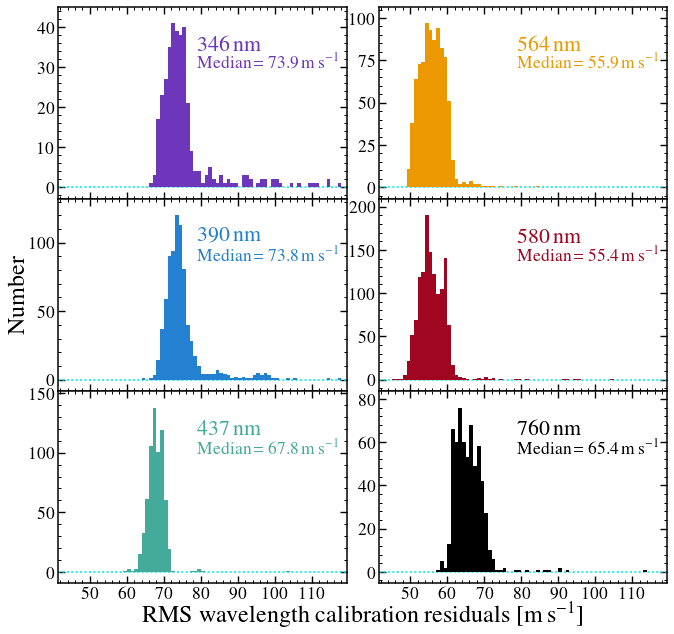

In [12]:
fig=plt.figure(figsize=(9.0,9.0))

# Good colour matches for the colourblind
myc={'violet':'#6E36BB','blue':'#2480D0','cyan':'#00E6E6','green':'#44AA99',
     'orange':'#EC9800','red':'#A00620','black':'#000000'}
colours=[myc['violet'],myc['blue'],myc['green'],myc['orange'],myc['red'],myc['black']]

bins=np.arange(42.0,120.0,1.0)
binwid=bins[1]-bins[0]

nrows,ncols=3,2
i=0
ax={}
for sett in [346,390,437,564,580,760]:
    col=int(np.modf(i/nrows)[1])
    row=int(i-col*nrows)
    ax[sett]=plt.subplot2grid((nrows,ncols),(row,col),rowspan=1,colspan=1)
    wavrms=[]
    for j in range(0,len(dDR1QSOs)):
        if (re.search('[345]',dDR1QSOs.Spec_status[j])) is None:
            filt=[(spec[j]['Exp']['Setting']==sett) & (spec[j]['Exp']['Binning']=='2x2') &
                  (spec[j]['Exp']['SlitWidth']==1.0)]
            [wavrms.append(w) for w in spec[j]['Exp']['WavcalRMS'][filt].tolist()]
    print(len(wavrms))
    n,e,_=ax[sett].hist(wavrms,bins,align='mid',histtype='stepfilled',lw=3.0,ls='-',color=colours[i],alpha=1.0,
                        label=r'%s' % sett,zorder=100)
    xmin,xmax=bins[0]-0.5*binwid,bins[-1]+0.5*binwid
    xrng=xmax-xmin
    ymax=max(n)
    ymin,ymax=-0.07*ymax,1.10*ymax
    yrng=ymax-ymin
    ax[sett].hlines([0.0],xmin,xmax,colors=myc['cyan'],linestyles=':',linewidths=1.5)
    ax[sett].set_xlim(xmin,xmax)
    ax[sett].set_ylim(ymin,ymax)
    ax[sett].xaxis.set_major_locator(MultipleLocator(10))
    ax[sett].xaxis.set_minor_locator(AutoMinorLocator(5))
    ax[sett].yaxis.set_minor_locator(AutoMinorLocator(5))
    ax[sett].annotate(r'%d\,nm' % sett,xy=(0.48,0.8),xycoords='axes fraction',
                      color=colours[i],ha='left',va='center',fontsize=bfsize)
    ax[sett].annotate(r'Median\,=\,%.1f\,m\,s$^{-1}$' % np.median(wavrms),xy=(0.48,0.7),xycoords='axes fraction',
                      color=colours[i],ha='left',va='center',fontsize=0.8*bfsize)
    if ((col==0) & (row==2)):
        ax[sett].annotate(r'RMS wavelength calibration residuals [m\,s$^{-1}$]',
                          xy=(1.055,-0.16),xycoords='axes fraction',color='black',
                          ha='center',va='center',fontsize=1.1*bfsize)
    if ((col==0) & (row==1)):
        ax[sett].annotate(r'Number',xy=(-0.14,0.5),xycoords='axes fraction',color='black',
                          ha='center',va='center',fontsize=1.1*bfsize,rotation='vertical')
    #ax1.set_ylabel(r'Number',ha='center',va='bottom',fontsize=bfsize)
    i+=1

fig.subplots_adjust(left=0.05,right=0.99,bottom=0.10,top=0.99,wspace=0.11,hspace=0.0)
# Export to PDF
#plt.savefig('DR1_wavcalrms_1p0_2x2.pdf',bbox_inches='tight',pad_inches=0.05)

# Example of correcting bad data in blue part of red arm spectra

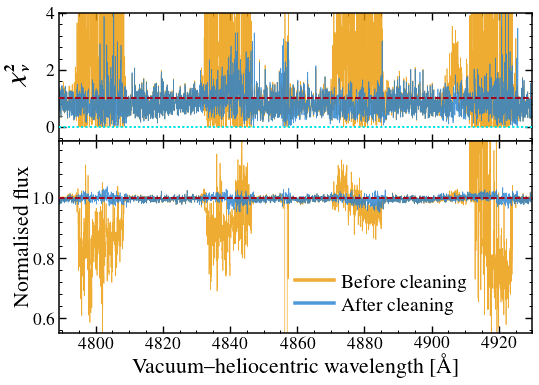

In [13]:
fig=plt.figure(figsize=(7.0,5.0))

# Good colour matches for the colourblind
myc={'violet':'#6E36BB','blue':'#2480D0','cyan':'#00E6E6','green':'#44AA99',
     'orange':'#EC9800','red':'#A00620','black':'#000000'}

# Use example of J014333-391700, the cleaned version of which is spec[83]
# and the pre-cleaned version is in J014333-391700_preclean.fits.
# Read in pre-cleaned and cleaned spectra
spreclean=rUVESpoplerFITS('J014333-391700_preclean.fits')
FITSfile=UVESdir+"/"+dDR1QSOs.Name_Adopt[83]+"/"+dDR1QSOs.Name_Adopt[83]+".fits"
sclean=rUVESpoplerFITS(FITSfile)

# Select data from both spectra
wlmin,wlmax=4789,4930
filtpc=(spreclean['wl']>=wlmin) & (spreclean['wl']<=wlmax)
wlpc,nfpc,nepc,cspc=spreclean['wl'][filtpc],spreclean['nf'][filtpc],spreclean['ne'][filtpc],spreclean['cs'][filtpc]
filtc=(sclean['wl']>=wlmin) & (sclean['wl']<=wlmax)
wlc,nfc,nec,csc=sclean['wl'][filtc],sclean['nf'][filtc],sclean['ne'][filtc],sclean['cs'][filtc]

# Plot the chisq. arrays
ax1=plt.subplot2grid((100,1),(0,0),rowspan=40,colspan=1)
xmin,xmax=wlmin,wlmax
xrng=xmax-xmin
ymin,ymax=-0.5,4.0
yrng=ymax-ymin
ax1.hlines([0.0,1.0],xmin,xmax,colors=[myc['cyan'],myc['red']],linestyles=[':','--'],linewidths=2.0,zorder=100)
ax1.step(wlpc,cspc,where='mid',lw=0.7,color=myc['orange'],alpha=0.8,rasterized=True)
ax1.step(wlc,csc,where='mid',lw=0.7,color=myc['blue'],alpha=0.8,rasterized=True)
ax1.xaxis.set_minor_locator(AutoMinorLocator(5))
ax1.yaxis.set_minor_locator(AutoMinorLocator(5))
ax1.set_ylabel(r'\boldmath{$\chi_\nu^2$}',ha='center',va='bottom',fontsize=bfsize,labelpad=13)
ax1.set_xlim(xmin,xmax)
ax1.set_ylim(ymin,ymax)

# Plot both spectra
ax2=plt.subplot2grid((100,1),(40,0),rowspan=61,colspan=1,sharex=ax1)
ymin,ymax=0.55,1.19
yrng=ymax-ymin
ax2.hlines([0.0,1.0],xmin,xmax,colors=myc['red'],linestyles=[':','--'],linewidths=2.0,zorder=100)
ax2.step(wlpc,nfpc,where='mid',lw=0.7,color=myc['orange'],alpha=0.8,rasterized=True,label=r'Before cleaning')
ax2.step(wlc,nfc,where='mid',lw=0.7,color=myc['blue'],alpha=0.8,rasterized=True,label=r'After cleaning')
ax2.set_xlabel(r'Vacuum--heliocentric wavelength [\AA]',ha='center',fontsize=bfsize)
ax2.set_ylabel(r'Normalised flux',ha='center',va='bottom',fontsize=bfsize)
ax2.set_xlim(xmin,xmax)
ax2.set_ylim(ymin,ymax)
ax2.xaxis.set_minor_locator(AutoMinorLocator(4))
ax2.yaxis.set_minor_locator(AutoMinorLocator(5))

# Joint legend for two axes
handles2,labels2=ax2.get_legend_handles_labels()
leg=ax2.legend(handles2,labels2,bbox_to_anchor=(0.68,0.4))
for legobj in leg.legendHandles:
    legobj.set_linewidth(3.5)

#leg.get_frame().set_alpha(0.6)


fig.subplots_adjust(left=0.05,right=0.99,bottom=0.10,top=0.99,wspace=0.0,hspace=0.0)
# Export to PDF
#plt.savefig('DR1_J014333-391700_baddata.pdf',bbox_inches='tight',pad_inches=0.05)

# Example comparing automatic and manual Lya forest continuum fits

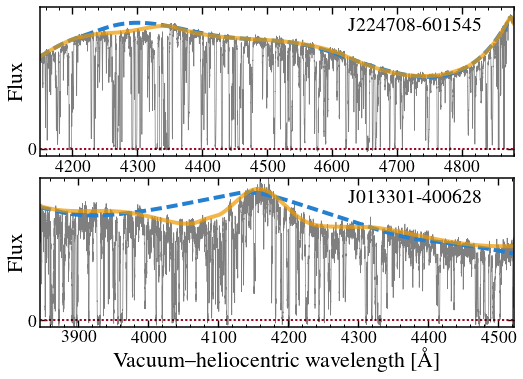

In [14]:
fig=plt.figure(figsize=(7.0,5.0))

# Good colour matches for the colourblind
myc={'violet':'#6E36BB','blue':'#2480D0','cyan':'#00E6E6','green':'#44AA99',
     'orange':'#EC9800','red':'#A00620','black':'#000000'}

## Top panel uses J224708-601545 as a "good" example of the automatic continuum fit
# Select data from both spectra
wlmin,wlmax=4150,4880
# Read in final version of spectrum
FITSfile=UVESdir+"/"+dDR1QSOs.Name_Adopt[430]+"/"+dDR1QSOs.Name_Adopt[430]+".fits"
s=rUVESpoplerFITS(FITSfile)
filt=((s['wl']>=wlmin) & (s['wl']<=wlmax))
wl,nf,co=s['wl'][filt],s['nf'][filt],s['co'][filt]
# Define a spline function to flatten out the spectrum a bit for plotting purposes
xnode=[4150,4500,4900]
ynode=[1.6,1.2,1.0]
spl=interpolate.spline(xnode,ynode,wl)
co=co*spl
f=nf*co
# Do the same for the version of the spectrum with the original continuum
s=rUVESpoplerFITS('J224708-601545_origcont.fits')
filt=((s['wl']>=wlmin) & (s['wl']<=wlmax))
wloc,cooc=s['wl'][filt],s['co'][filt]
sploc=interpolate.spline(xnode,ynode,wloc)
cooc=cooc*sploc
# Plot the spectrum
ax1=plt.subplot2grid((2,1),(0,0),rowspan=1,colspan=1)
xmin,xmax=wlmin,wlmax
xrng=xmax-xmin
ymax=1.08*max(np.amax(co),np.amax(cooc))
ymin=-0.05*ymax
yrng=ymax-ymin
ax1.hlines(0.0,xmin,xmax,colors=myc['red'],linestyles=':',linewidths=2.0)
ax1.step(wl,f,where='mid',lw=0.7,color=myc['black'],alpha=0.5,rasterized=True,label=r'Final spectrum')
ax1.plot(wl,cooc,lw=4.0,color=myc['blue'],ls='--',alpha=1.0,rasterized=True,label=r'Automatic continuum')
ax1.plot(wl,co,lw=4.0,color=myc['orange'],alpha=0.7,rasterized=True,label=r'Manual continuum')
ax1.set_ylabel(r'Flux',ha='center',va='bottom',fontsize=bfsize)
ax1.yaxis.set_ticks([0])
ax1.annotate(r'%s' % dDR1QSOs.Name_Adopt[430],xy=(0.65,0.87),xycoords='axes fraction',color='black',
             ha='left',va='center',fontsize=0.9*bfsize)
ax1.set_xlim(xmin,xmax)
ax1.set_ylim(ymin,ymax)
ax1.xaxis.set_minor_locator(AutoMinorLocator(5))


## Bottom panel uses J013301-400628 as a "bad" example of the automatic continuum fit
# Select data from both spectra
wlmin,wlmax=3845,4522
# Read in final version of spectrum
FITSfile=UVESdir+"/"+dDR1QSOs.Name_Adopt[70]+"/"+dDR1QSOs.Name_Adopt[70]+".fits"
s=rUVESpoplerFITS(FITSfile)
filt=((s['wl']>=wlmin) & (s['wl']<=wlmax))
wl,nf,co=s['wl'][filt],s['nf'][filt],s['co'][filt]
# Define a spline function to flatten out the spectrum a bit for plotting purposes
xnode=[3845,4150,4350,4522]
ynode=[2.8,2.0,1.5,1.0]
spl=interpolate.spline(xnode,ynode,wl)
co=co*spl
f=nf*co
# Do the same for the version of the spectrum with the original continuum
s=rUVESpoplerFITS('J013301-400628_origcont.fits')
filt=((s['wl']>=wlmin) & (s['wl']<=wlmax))
wloc,cooc=s['wl'][filt],s['co'][filt]
sploc=interpolate.spline(xnode,ynode,wloc)
cooc=cooc*sploc
# Plot the spectrum
ax2=plt.subplot2grid((2,1),(1,0),rowspan=1,colspan=1)
xmin,xmax=wlmin,wlmax
xrng=xmax-xmin
ymax=1.08*max(np.amax(co),np.amax(cooc))
ymin=-0.05*ymax
yrng=ymax-ymin
ax2.hlines(0.0,xmin,xmax,colors=myc['red'],linestyles=':',linewidths=2.0)
ax2.step(wl,f,where='mid',lw=0.7,color=myc['black'],alpha=0.5,rasterized=True,label=r'Final spectrum')
ax2.plot(wl,cooc,lw=4.0,color=myc['blue'],ls='--',alpha=1.0,rasterized=True,label=r'Automatic continuum')
ax2.plot(wl,co,lw=4.0,color=myc['orange'],alpha=0.7,rasterized=True,label=r'Manual continuum')
ax2.set_xlabel(r'Vacuum--heliocentric wavelength [\AA]',ha='center',fontsize=bfsize)
ax2.set_ylabel(r'Flux',ha='center',va='bottom',fontsize=bfsize)
ax2.yaxis.set_ticks([0])
ax2.annotate(r'%s' % dDR1QSOs.Name_Adopt[70],xy=(0.65,0.87),xycoords='axes fraction',color='black',
             ha='left',va='center',fontsize=0.9*bfsize)
ax2.set_xlim(xmin,xmax)
ax2.set_ylim(ymin,ymax)
ax2.xaxis.set_minor_locator(AutoMinorLocator(5))

# Joint legend for two axes
#handles2,labels2=ax2.get_legend_handles_labels()
#leg=ax2.legend(handles2,labels2,bbox_to_anchor=(0.68,0.4))
#for legobj in leg.legendHandles:
#    legobj.set_linewidth(3.5)
#leg.get_frame().set_alpha(0.6)

fig.subplots_adjust(left=0.05,right=0.99,bottom=0.10,top=0.99,wspace=0.1,hspace=0.15)
# Export to PDF
#plt.savefig('DR1_Lya_cont.pdf',bbox_inches='tight',pad_inches=0.05)

# Examples of continuum overestimate in low-SNR regions

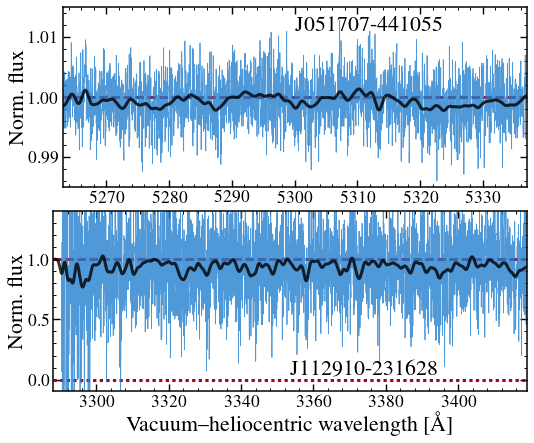

In [12]:
fig=plt.figure(figsize=(7.0,6.0))

# Good colour matches for the colourblind
myc={'violet':'#6E36BB','blue':'#2480D0','cyan':'#00E6E6','green':'#44AA99',
     'orange':'#EC9800','red':'#A00620','black':'#000000'}

# Use J051707-441055 (number 179) as an example of high-SNR continuum placement
wlmin1,wlmax1=5263,5337
FITSfile=UVESdir+"/"+dDR1QSOs.Name_Adopt[179]+"/"+dDR1QSOs.Name_Adopt[179]+".fits"
s=rUVESpoplerFITS(FITSfile)
filt1=((s['wl']>=wlmin1) & (s['wl']<=wlmax1))
wl1,nf1,ne1=s['wl'][filt1],s['nf'][filt1],s['ne'][filt1]
sm1=filters.gaussian_filter1d(nf1,20.0)
# Use J112910-231628 (number 260) as an example of bias in continuum at low SNR
wlmin2,wlmax2=3288,3419
FITSfile=UVESdir+"/"+dDR1QSOs.Name_Adopt[260]+"/"+dDR1QSOs.Name_Adopt[260]+".fits"
s=rUVESpoplerFITS(FITSfile)
filt2=((s['wl']>=wlmin2) & (s['wl']<=wlmax2))
wl2,nf2,ne2=s['wl'][filt2],s['nf'][filt2],s['ne'][filt2]
sm2=filters.gaussian_filter1d(nf2,20.0)

## Top panel: high S/N spectrum
ax1=plt.subplot2grid((2,50),(0,1),rowspan=1,colspan=49)
xmin,xmax=wlmin1,wlmax1
xrng=xmax-xmin
ymax=1.015
ymin=0.985
yrng=ymax-ymin
ax1.hlines([0.0,1.0],xmin,xmax,colors=myc['red'],linestyles=[':','--'],linewidths=3.0)
ax1.step(wl1,nf1,where='mid',lw=0.8,color=myc['blue'],alpha=0.8,rasterized=True)
ax1.plot(wl1,sm1,lw=3.0,color=myc['black'],ls='-',alpha=0.8,rasterized=True)
ax1.annotate(r'%s' % dDR1QSOs.Name_Adopt[179],xy=(0.5,0.90),xycoords='axes fraction',color=myc['black'],
             ha='left',va='center',fontsize=bfsize)
ax1.set_ylabel(r'Norm.\ flux',ha='center',va='bottom',fontsize=bfsize)
ax1.xaxis.set_minor_locator(AutoMinorLocator(5))
ax1.yaxis.set_minor_locator(AutoMinorLocator(5))
ax1.set_xlim(xmin,xmax)
ax1.set_ylim(ymin,ymax)

## Bottom panel: Low S/N spectrum
ax2=plt.subplot2grid((2,1),(1,0),rowspan=1,colspan=1)
xmin,xmax=wlmin2,wlmax2
xrng=xmax-xmin
ymax=1.40
ymin=-0.07*ymax
yrng=ymax-ymin
ax2.hlines([0.0,1.0],xmin,xmax,colors=myc['red'],linestyles=[':','--'],linewidths=3.0)
ax2.step(wl2,nf2,where='mid',lw=0.8,color=myc['blue'],alpha=0.8,rasterized=True)
ax2.plot(wl2,sm2,lw=3.0,color=myc['black'],ls='-',alpha=0.8,rasterized=True)
ax2.annotate(r'%s' % dDR1QSOs.Name_Adopt[260],xy=(0.5,0.11),xycoords='axes fraction',color=myc['black'],
             ha='left',va='center',fontsize=bfsize)
ax2.set_ylabel(r'Norm.\ flux',ha='center',va='bottom',fontsize=bfsize)
ax2.set_xlabel(r'Vacuum--heliocentric wavelength [\AA]',ha='center',fontsize=bfsize)
ax2.xaxis.set_minor_locator(AutoMinorLocator(5))
ax2.yaxis.set_minor_locator(AutoMinorLocator(5))
ax2.set_xlim(xmin,xmax)
ax2.set_ylim(ymin,ymax)

fig.subplots_adjust(left=0.05,right=0.99,bottom=0.10,top=0.99,wspace=0.0,hspace=0.13)
# Export to PDF
#plt.savefig('DR1_cont_overestimate.pdf',bbox_inches='tight',pad_inches=0.05)

# Plot showing main telluric features in DR1 spectra

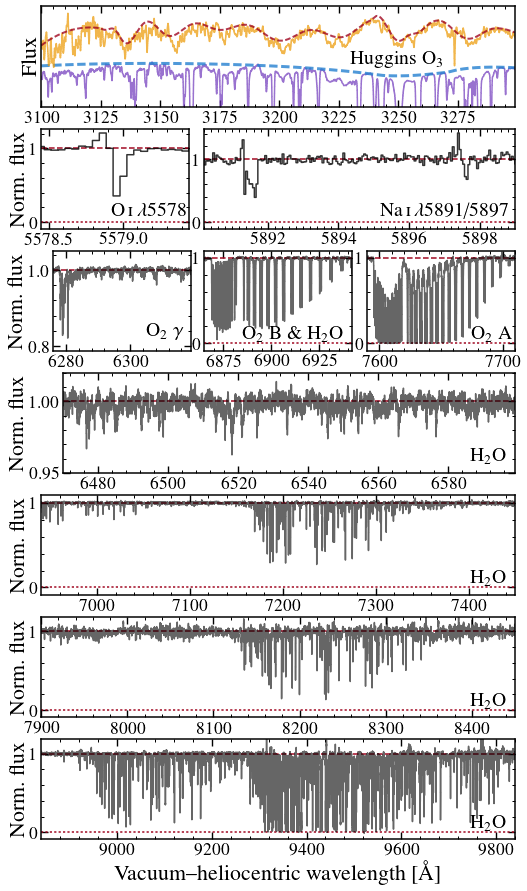

In [36]:
fig=plt.figure(figsize=(7.0,13.0))

# Good colour matches for the colourblind
myc={'violet':'#6E36BB','blue':'#2480D0','cyan':'#00E6E6','green':'#44AA99',
     'orange':'#EC9800','red':'#A00620','black':'#000000'}

# Use J051707-441055 (number 179) for Huggins ozone bands, ...
wlmin,wlmax=3100,3400
FITSfile=UVESdir+"/"+dDR1QSOs.Name_Adopt[179]+"/"+dDR1QSOs.Name_Adopt[179]+".fits"
s=rUVESpoplerFITS(FITSfile)
filt=((s['wl']>=wlmin) & (s['wl']<=wlmax))
wl1,nf1,co1=s['wl'][filt],s['nf'][filt],s['co'][filt]
nf1=filters.gaussian_filter1d(nf1,6.0)
xnode=[3100,3150,3200,3250,3300]
ynode=[1.2,1.1,1.0,0.92,0.85]
spl=interpolate.spline(xnode,ynode,wl1)
co1=co1*spl
# and J083052+241059 as an example of where the Huggins bands were fit out
wlmin,wlmax=3100,3400
FITSfile=UVESdir+"/"+dDR1QSOs.Name_Adopt[194]+"/"+dDR1QSOs.Name_Adopt[194]+".fits"
s=rUVESpoplerFITS(FITSfile)
filt=((s['wl']>=wlmin) & (s['wl']<=wlmax))
wl2,nf2,co2=s['wl'][filt],s['nf'][filt],s['co'][filt]
nf2=filters.gaussian_filter1d(nf2,6.0)
xnode=[3100,3150,3200,3250,3300]
ynode=[60,70,70,85,100]
spl=interpolate.spline(xnode,ynode,wl2)
co2=co2*spl
# Plot the Huggins band regions
ax1=plt.subplot2grid((7,1),(0,0),rowspan=1,colspan=1)
xmin,xmax=3100.0,3299.0
xrng=xmax-xmin
filt1=((wl1>=xmin) & (wl1<=xmax))
filt2=((wl2>=xmin) & (wl2<=xmax))
ymax=1.05*max(np.amax(co1[filt1]),np.amax(co2[filt2]))
ymin=0.5*ymax
yrng=ymax-ymin
ax1.hlines(0.0,xmin,xmax,colors=myc['red'],linestyles=':',linewidths=2.0)
ax1.step(wl1[filt1],nf1[filt1]*co1[filt1],where='mid',lw=1.5,color=myc['violet'],alpha=0.7,
         rasterized=True,label=r'J051707-441055')
ax1.plot(wl1[filt1],co1[filt1],lw=3.0,color=myc['blue'],ls='--',alpha=0.8,rasterized=True)
ax1.step(wl2[filt2],nf2[filt2]*co2[filt2],where='mid',lw=1.5,color=myc['orange'],alpha=0.7,
         rasterized=True,label=r'J083052+241059')
ax1.plot(wl2[filt2],co2[filt2],lw=2.0,color=myc['red'],ls='--',alpha=0.8,rasterized=True)
ax1.set_ylabel(r'Flux',ha='center',va='bottom',fontsize=bfsize)
ax1.annotate(r'Huggins O$_3$',xy=(0.75,0.45),xycoords='axes fraction',color='black',
             ha='center',va='center',fontsize=0.9*bfsize)
ax1.yaxis.set_ticks([])
ax1.set_xlim(xmin,xmax)
ax1.set_ylim(ymin,ymax)
ax1.xaxis.set_minor_locator(AutoMinorLocator(5))

# J124913-055919 for 5580 skyline
wlmin,wlmax=5500,5600
FITSfile=UVESdir+"/"+dDR1QSOs.Name_Adopt[295]+"/"+dDR1QSOs.Name_Adopt[295]+".fits"
s=rUVESpoplerFITS(FITSfile)
filt=((s['wl']>=wlmin) & (s['wl']<=wlmax))
wl1,nf1,co1=s['wl'][filt],s['nf'][filt],s['co'][filt]
# Plot the 5580 skyline
ax2=plt.subplot2grid((7,3),(1,0),rowspan=1,colspan=1)
xmin,xmax=5578.45,5579.45
xrng=xmax-xmin
ymax=1.05*np.amax(nf1)
ymin=-0.07*ymax
yrng=ymax-ymin
ax2.hlines([0.0,1.0],xmin,xmax,colors=myc['red'],linestyles=[':','--'],linewidths=1.5)
ax2.step(wl1,nf1,where='mid',lw=1.5,color=myc['black'],alpha=0.8,rasterized=True)
ax2.annotate(r'O{\sc \,i}\,$\lambda$5578',xy=(0.98,0.18),xycoords='axes fraction',color='black',
             ha='right',va='center',fontsize=0.9*bfsize)
ax2.set_ylabel(r'Norm.\ flux',ha='center',va='bottom',fontsize=bfsize)
ax2.set_xlim(xmin,xmax)
ax2.set_ylim(ymin,ymax)
ax2.xaxis.set_minor_locator(AutoMinorLocator(5))
ax2.yaxis.set_minor_locator(AutoMinorLocator(5))

# J001306+000431 for Na D doublet
wlmin,wlmax=5850,5950
FITSfile=UVESdir+"/"+dDR1QSOs.Name_Adopt[11]+"/"+dDR1QSOs.Name_Adopt[11]+".fits"
s=rUVESpoplerFITS(FITSfile)
filt=((s['wl']>=wlmin) & (s['wl']<=wlmax))
wl1,nf1,co1=s['wl'][filt],s['nf'][filt],s['co'][filt]
# Plot the Na D doublet skyline
ax3=plt.subplot2grid((7,3),(1,1),rowspan=1,colspan=2)
xmin,xmax=5890.2,5899.0
xrng=xmax-xmin
ymax=1.05*np.amax(nf1)
ymin=-0.07*ymax
yrng=ymax-ymin
ax3.hlines([0.0,1.0],xmin,xmax,colors=myc['red'],linestyles=[':','--'],linewidths=1.5)
ax3.step(wl1,nf1,where='mid',lw=1.5,color=myc['black'],alpha=0.8,rasterized=True)
ax3.annotate(r'Na{\sc \,i}\,$\lambda$5891/5897',xy=(0.98,0.18),xycoords='axes fraction',color='black',
             ha='right',va='center',fontsize=0.9*bfsize)
ax3.set_xlim(xmin,xmax)
ax3.set_ylim(ymin,ymax)
ax3.xaxis.set_minor_locator(AutoMinorLocator(10))
ax3.yaxis.set_minor_locator(AutoMinorLocator(5))

# J051707-441055 for the remaining O2 and H2O bands
wlmin,wlmax=6250,9900
FITSfile=UVESdir+"/"+dDR1QSOs.Name_Adopt[179]+"/"+dDR1QSOs.Name_Adopt[179]+".fits"
s=rUVESpoplerFITS(FITSfile)
filt=((s['wl']>=wlmin) & (s['wl']<=wlmax))
wl1,nf1,co1=s['wl'][filt],s['nf'][filt],s['co'][filt]

# Plot the O2 gamma band
ax4=plt.subplot2grid((7,120),(2,3),rowspan=1,colspan=35)
xmin,xmax=6276,6319
xrng=xmax-xmin
ymax=1.05
ymin=0.75*ymax
yrng=ymax-ymin
ax4.hlines([0.0,1.0],xmin,xmax,colors=myc['red'],linestyles=[':','--'],linewidths=1.5)
ax4.step(wl1,nf1,where='mid',lw=1.5,color=myc['black'],alpha=0.6,rasterized=True)
ax4.annotate(r'O$_2$ $\gamma$',xy=(0.94,0.17),xycoords='axes fraction',color='black',
             ha='right',va='center',fontsize=0.9*bfsize)
ax4.set_ylabel(r'Norm.\ flux',ha='center',va='bottom',fontsize=bfsize)
ax4.set_xlim(xmin,xmax)
ax4.set_ylim(ymin,ymax)
ax4.xaxis.set_minor_locator(AutoMinorLocator(5))
ax4.yaxis.set_minor_locator(AutoMinorLocator(5))

# Plot the B band
ax5=plt.subplot2grid((7,3),(2,1),rowspan=1,colspan=1)
xmin,xmax=6865,6942
xrng=xmax-xmin
ymax=1.08
ymin=-0.08*ymax
yrng=ymax-ymin
ax5.hlines([0.0,1.0],xmin,xmax,colors=myc['red'],linestyles=[':','--'],linewidths=1.5)
ax5.step(wl1,nf1,where='mid',lw=1.5,color=myc['black'],alpha=0.6,rasterized=True)
ax5.annotate(r'O$_2$ B \& H$_2$O',xy=(0.94,0.14),xycoords='axes fraction',color='black',
             ha='right',va='center',fontsize=0.9*bfsize)
ax5.set_xlim(xmin,xmax)
ax5.set_ylim(ymin,ymax)
ax5.xaxis.set_minor_locator(AutoMinorLocator(5))
ax5.yaxis.set_minor_locator(AutoMinorLocator(5))

# Plot the A band
ax6=plt.subplot2grid((7,3),(2,2),rowspan=1,colspan=1)
xmin,xmax=7590,7710
xrng=xmax-xmin
ymax=1.08
ymin=-0.08*ymax
yrng=ymax-ymin
ax6.hlines([0.0,1.0],xmin,xmax,colors=myc['red'],linestyles=[':','--'],linewidths=1.5)
ax6.step(wl1,nf1,where='mid',lw=1.5,color=myc['black'],alpha=0.6,rasterized=True)
ax6.annotate(r'O$_2$ A',xy=(0.98,0.14),xycoords='axes fraction',color='black',
             ha='right',va='center',fontsize=0.9*bfsize)
ax6.set_xlim(xmin,xmax)
ax6.set_ylim(ymin,ymax)
ax6.xaxis.set_minor_locator(AutoMinorLocator(10))
ax6.yaxis.set_minor_locator(AutoMinorLocator(5))

# Plot H2O band at 6470--6600
ax7=plt.subplot2grid((7,22),(3,1),rowspan=1,colspan=21)
xmin,xmax=6470,6599
xrng=xmax-xmin
ymax=1.02
ymin=0.95
yrng=ymax-ymin
ax7.hlines([0.0,1.0],xmin,xmax,colors=myc['red'],linestyles=[':','--'],linewidths=1.5)
ax7.step(wl1,nf1,where='mid',lw=1.5,color=myc['black'],alpha=0.6,rasterized=True)
ax7.annotate(r'H$_2$O',xy=(0.98,0.14),xycoords='axes fraction',color='black',
             ha='right',va='center',fontsize=0.9*bfsize)
ax7.set_ylabel(r'Norm.\ flux',ha='center',va='bottom',fontsize=bfsize)
ax7.set_xlim(xmin,xmax)
ax7.set_ylim(ymin,ymax)
ax7.xaxis.set_minor_locator(AutoMinorLocator(5))
ax7.yaxis.set_minor_locator(AutoMinorLocator(5))

# Plot H2O band at 6830--7450 (but not plotting what was already plotted for O2 B)
ax8=plt.subplot2grid((7,1),(4,0),rowspan=1,colspan=1)
xmin,xmax=6940,7450
xrng=xmax-xmin
ymax=1.09
ymin=-0.09
yrng=ymax-ymin
ax8.hlines([0.0,1.0],xmin,xmax,colors=myc['red'],linestyles=[':','--'],linewidths=1.5)
ax8.step(wl1,nf1,where='mid',lw=1.5,color=myc['black'],alpha=0.6,rasterized=True)
ax8.annotate(r'H$_2$O',xy=(0.98,0.14),xycoords='axes fraction',color='black',
             ha='right',va='center',fontsize=0.9*bfsize)
ax8.set_ylabel(r'Norm.\ flux',ha='center',va='bottom',fontsize=bfsize)
ax8.set_xlim(xmin,xmax)
ax8.set_ylim(ymin,ymax)
ax8.xaxis.set_minor_locator(AutoMinorLocator(5))
ax8.yaxis.set_minor_locator(AutoMinorLocator(5))

# Plot H2O band at 7820--8620
ax9=plt.subplot2grid((7,1),(5,0),rowspan=1,colspan=1)
xmin,xmax=7900,8450
xrng=xmax-xmin
ymax=1.18
ymin=-0.09
yrng=ymax-ymin
ax9.hlines([0.0,1.0],xmin,xmax,colors=myc['red'],linestyles=[':','--'],linewidths=1.5)
ax9.step(wl1,nf1,where='mid',lw=1.5,color=myc['black'],alpha=0.6,rasterized=True)
ax9.annotate(r'H$_2$O',xy=(0.98,0.14),xycoords='axes fraction',color='black',
             ha='right',va='center',fontsize=0.9*bfsize)
ax9.set_ylabel(r'Norm.\ flux',ha='center',va='bottom',fontsize=bfsize)
ax9.set_xlim(xmin,xmax)
ax9.set_ylim(ymin,ymax)
ax9.xaxis.set_minor_locator(AutoMinorLocator(5))
ax9.yaxis.set_minor_locator(AutoMinorLocator(5))

# Plot H2O band at 8840--9840
ax10=plt.subplot2grid((7,1),(6,0),rowspan=1,colspan=1)
xmin,xmax=8840,9840
xrng=xmax-xmin
ymax=1.18
ymin=-0.09
yrng=ymax-ymin
ax10.hlines([0.0,1.0],xmin,xmax,colors=myc['red'],linestyles=[':','--'],linewidths=1.5)
ax10.step(wl1,nf1,where='mid',lw=1.5,color=myc['black'],alpha=0.6,rasterized=True)
ax10.annotate(r'H$_2$O',xy=(0.98,0.14),xycoords='axes fraction',color='black',
             ha='right',va='center',fontsize=0.9*bfsize)
ax10.set_ylabel(r'Norm.\ flux',ha='center',va='bottom',fontsize=bfsize)
ax10.set_xlabel(r'Vacuum--heliocentric wavelength [\AA]',ha='center',fontsize=bfsize)
ax10.set_xlim(xmin,xmax)
ax10.set_ylim(ymin,ymax)
ax10.xaxis.set_minor_locator(AutoMinorLocator(5))
ax10.yaxis.set_minor_locator(AutoMinorLocator(5))

fig.subplots_adjust(left=0.05,right=0.99,bottom=0.10,top=0.99,wspace=0.10,hspace=0.22)
# Export to PDF
#plt.savefig('DR1_telluric.pdf',bbox_inches='tight',pad_inches=0.05)

# Plot showing remaining cosmic ray in saturated line

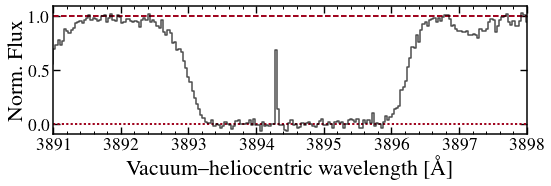

In [41]:
fig=plt.figure(figsize=(7.0,2.0))

# Good colour matches for the colourblind
myc={'violet':'#6E36BB','blue':'#2480D0','cyan':'#00E6E6','green':'#44AA99',
     'orange':'#EC9800','red':'#A00620','black':'#000000'}

# Use J033108-252443 (number 135) as an example
wlmin,wlmax=3890,3900
FITSfile=UVESdir+"/"+dDR1QSOs.Name_Adopt[135]+"/"+dDR1QSOs.Name_Adopt[135]+".fits"
s=rUVESpoplerFITS(FITSfile)
filt=((s['wl']>=wlmin) & (s['wl']<=wlmax))
wl,nf,co=s['wl'][filt],s['nf'][filt],s['co'][filt]
# Plot the cosmic ray example
ax1=plt.subplot2grid((1,1),(0,0),rowspan=1,colspan=1)
xmin,xmax=3891.0,3898.0
xrng=xmax-xmin
ymax=1.09
ymin=-0.09*ymax
yrng=ymax-ymin
ax1.hlines([0.0,1.0],xmin,xmax,colors=myc['red'],linestyles=[':','--'],linewidths=2.0)
ax1.step(wl,nf,where='mid',lw=1.5,color=myc['black'],alpha=0.7,rasterized=True)
ax1.set_xlabel(r'Vacuum--heliocentric wavelength [\AA]',ha='center',fontsize=bfsize)
ax1.set_ylabel(r'Norm.\ Flux',ha='center',va='bottom',fontsize=bfsize)
ax1.set_xlim(xmin,xmax)
ax1.set_ylim(ymin,ymax)
ax1.xaxis.set_minor_locator(AutoMinorLocator(5))

fig.subplots_adjust(left=0.05,right=0.99,bottom=0.10,top=0.99,wspace=0.10,hspace=0.22)
# Export to PDF
#plt.savefig('DR1_cosmic.pdf',bbox_inches='tight',pad_inches=0.05)

# Plot showing main unidentified features in DR1 spectra

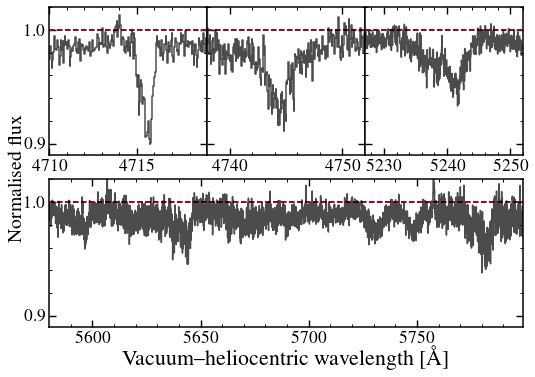

In [98]:
fig=plt.figure(figsize=(7.0,5.0))

# Good colour matches for the colourblind
myc={'violet':'#6E36BB','blue':'#2480D0','cyan':'#00E6E6','green':'#44AA99',
     'orange':'#EC9800','red':'#A00620','black':'#000000'}

# Read in clipped mean composite spectrum for z<1.5 DR1 spectra
FITSfile='DR1_zlt1.5_ClipMeanComp.fits'
s=rDR1CompositeFITS(FITSfile)
wl,nf=s['wl'],s['nf']

# Plot the main features in different panels
xmin=[4710,4738,5227,5580]
xmax=[4719,4752,5252,5799]
ymin=[0.89,0.89,0.89,0.89]
ymax=[1.02,1.02,1.02,1.02]
row=[0,0,0,1]
col=[0,1,2,0]
colspan=[1,1,1,1]
nrows=2
ncols=[3,3,3,1]
ax={}
for i in range(0,4):
    ax[i]=plt.subplot2grid((nrows,ncols[i]),(row[i],col[i]),rowspan=1,colspan=colspan[i])
    xrng=xmax[i]-xmin[i]
    yrng=ymax[i]-ymin[i]
    filt=(wl>=xmin[i]) & (wl<=xmax[i])
    ax[i].hlines([0.0,1.0],xmin[i],xmax[i],colors=myc['red'],linestyles=[':','--'],linewidths=2.0)
    ax[i].step(wl[filt],nf[filt],where='mid',lw=1.5,color=myc['black'],alpha=0.7,rasterized=True)
    ax[i].xaxis.set_minor_locator(AutoMinorLocator(5))
    ax[i].yaxis.set_major_locator(MultipleLocator(0.1))
    ax[i].yaxis.set_minor_locator(AutoMinorLocator(5))
    ax[i].set_xlim(xmin[i],xmax[i])
    ax[i].set_ylim(ymin[i],ymax[i])
    if (col[i]!=0): ax[i].axes.get_yaxis().set_ticklabels([])
    if (i==3):
        ax[i].set_xlabel(r'Vacuum--heliocentric wavelength [\AA]',ha='center',fontsize=bfsize,labelpad=-1)
        ax[i].annotate(r'Normalised flux',xy=(-0.07,1.0),xycoords='axes fraction',color='black',
             ha='center',va='center',rotation=90,fontsize=0.9*bfsize)

fig.subplots_adjust(left=0.05,right=0.99,bottom=0.10,top=0.99,wspace=0.0,hspace=0.16)
# Export to PDF
#plt.savefig('DR1_unidentified.pdf',bbox_inches='tight',pad_inches=0.05)

# Plot showing high $\chi^2_\nu$ values at low flux levels

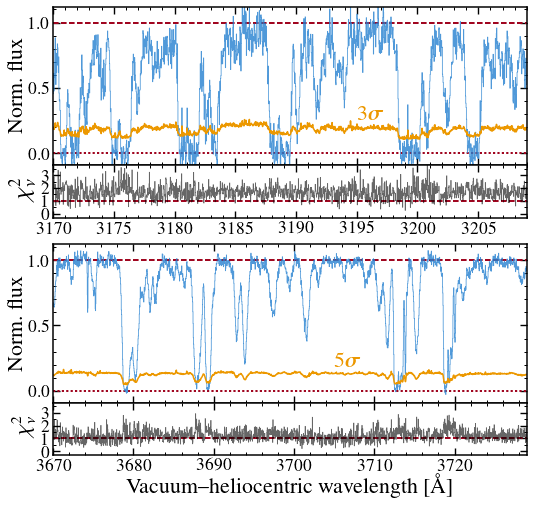

In [141]:
fig=plt.figure(figsize=(7.0,7.0))

# Good colour matches for the colourblind
myc={'violet':'#6E36BB','blue':'#2480D0','cyan':'#00E6E6','green':'#44AA99',
     'orange':'#EC9800','red':'#A00620','black':'#000000'}

# Use J033108-252443 (number 135) as an example
wlmin1,wlmax1=3170,3209
FITSfile=UVESdir+"/"+dDR1QSOs.Name_Adopt[135]+"/"+dDR1QSOs.Name_Adopt[135]+".fits"
s=rUVESpoplerFITS(FITSfile)
filt1=((s['wl']>=wlmin1) & (s['wl']<=wlmax1))
wl1,nf1,ne1,cs1=s['wl'][filt1],s['nf'][filt1],s['ne'][filt1],s['cs'][filt1]
wlmin2,wlmax2=3670,3729
filt2=((s['wl']>=wlmin2) & (s['wl']<=wlmax2))
wl2,nf2,ne2,cs2=s['wl'][filt2],s['nf'][filt2],s['ne'][filt2],s['cs'][filt2]

## Top panels plot a generally low SNR region
# Flux panel
ax1=plt.subplot2grid((17,1),(0,0),rowspan=6,colspan=1)
xmin,xmax=wlmin1,wlmax1
xrng=xmax-xmin
ymax=1.12
ymin=-0.08*ymax
yrng=ymax-ymin
ax1.hlines([0.0,1.0],xmin,xmax,colors=myc['red'],linestyles=[':','--'],linewidths=2.0)
ax1.step(wl1,nf1,where='mid',lw=0.8,color=myc['blue'],alpha=0.8,rasterized=True)
ax1.plot(wl1,3.0*ne1,lw=1.5,color=myc['orange'],ls='-',alpha=1.0,rasterized=True)
ax1.set_ylabel(r'Norm.\ flux',ha='center',va='bottom',fontsize=bfsize)
ax1.annotate(r'\boldmath{3$\sigma$}',xy=(0.67,0.32),xycoords='axes fraction',color=myc['orange'],
             ha='center',va='center',fontsize=bfsize)
ax1.axes.get_xaxis().set_ticklabels([])
ax1.xaxis.set_minor_locator(AutoMinorLocator(5))
ax1.yaxis.set_minor_locator(AutoMinorLocator(5))
ax1.set_xlim(xmin,xmax)
ax1.set_ylim(ymin,ymax)
# Chisq. panel
ax2=plt.subplot2grid((17,1),(6,0),rowspan=2,colspan=1)
ymax=3.8
ymin=-0.09*ymax
yrng=ymax-ymin
ax2.hlines(1.0,xmin,xmax,colors=myc['red'],linestyles='--',linewidths=2.0)
ax2.step(wl1,cs1,where='mid',lw=0.7,color=myc['black'],alpha=0.6,rasterized=True)
ax2.set_ylabel(r'$\chi^2_\nu$',ha='center',va='bottom',fontsize=1.1*bfsize)
ax2.xaxis.set_minor_locator(AutoMinorLocator(5))
ax2.yaxis.set_major_locator(MultipleLocator(1))
ax2.yaxis.set_minor_locator(AutoMinorLocator(2))
ax2.set_xlim(xmin,xmax)
ax2.set_ylim(ymin,ymax)

## Bottom panels plot a higher SNR region
# Flux panel
ax3=plt.subplot2grid((17,1),(9,0),rowspan=6,colspan=1)
xmin,xmax=wlmin2,wlmax2
xrng=xmax-xmin
ymax=1.12
ymin=-0.08*ymax
yrng=ymax-ymin
ax3.hlines([0.0,1.0],xmin,xmax,colors=myc['red'],linestyles=[':','--'],linewidths=2.0)
ax3.step(wl2,nf2,where='mid',lw=0.8,color=myc['blue'],alpha=0.8,rasterized=True)
ax3.plot(wl2,5.0*ne2,lw=1.5,color=myc['orange'],ls='-',alpha=1.0,rasterized=True)
ax3.set_ylabel(r'Norm.\ flux',ha='center',va='bottom',fontsize=bfsize)
ax3.annotate(r'\boldmath{5$\sigma$}',xy=(0.62,0.26),xycoords='axes fraction',color=myc['orange'],
             ha='center',va='center',fontsize=bfsize)
ax3.axes.get_xaxis().set_ticklabels([])
ax3.xaxis.set_minor_locator(AutoMinorLocator(5))
ax3.yaxis.set_minor_locator(AutoMinorLocator(5))
ax3.set_xlim(xmin,xmax)
ax3.set_ylim(ymin,ymax)
# Chisq. panel
ax4=plt.subplot2grid((17,1),(15,0),rowspan=2,colspan=1)
ymax=3.8
ymin=-0.09*ymax
yrng=ymax-ymin
ax4.hlines(1.0,xmin,xmax,colors=myc['red'],linestyles='--',linewidths=2.0)
ax4.step(wl2,cs2,where='mid',lw=0.7,color=myc['black'],alpha=0.6,rasterized=True)
ax4.set_ylabel(r'$\chi^2_\nu$',ha='center',va='bottom',fontsize=bfsize)
ax4.set_xlabel(r'Vacuum--heliocentric wavelength [\AA]',ha='center',fontsize=bfsize,labelpad=-1)
ax4.xaxis.set_minor_locator(AutoMinorLocator(5))
ax4.yaxis.set_major_locator(MultipleLocator(1))
ax4.yaxis.set_minor_locator(AutoMinorLocator(2))
ax4.set_xlim(xmin,xmax)
ax4.set_ylim(ymin,ymax)

fig.subplots_adjust(left=0.05,right=0.99,bottom=0.10,top=0.99,wspace=0.1,hspace=0.0)
# Export to PDF
#plt.savefig('DR1_unc_underestimate.pdf',bbox_inches='tight',pad_inches=0.05)

## Examples of zero-level problems in some spectra

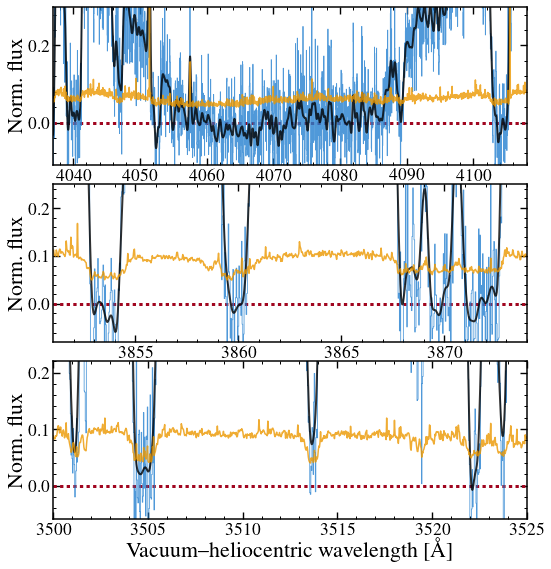

In [61]:
fig=plt.figure(figsize=(7.0,8.0))

# Good colour matches for the colourblind
myc={'violet':'#6E36BB','blue':'#2480D0','cyan':'#00E6E6','green':'#44AA99',
     'orange':'#EC9800','red':'#A00620','black':'#000000'}

# Use J020900-455026 (number 93) as an example of low and variable zero level (top two panels)
FITSfile=UVESdir+"/"+dDR1QSOs.Name_Adopt[93]+"/"+dDR1QSOs.Name_Adopt[93]+".fits"
s=rUVESpoplerFITS(FITSfile)
wlmin1,wlmax1=4037,4108
filt1=((s['wl']>=wlmin1) & (s['wl']<=wlmax1))
wl1,nf1,ne1=s['wl'][filt1],s['nf'][filt1],s['ne'][filt1]
wlmin2,wlmax2=3851,3874
filt2=((s['wl']>=wlmin2) & (s['wl']<=wlmax2))
wl2,nf2,ne2=s['wl'][filt2],s['nf'][filt2],s['ne'][filt2]
# Use J231359-370446 (number 440) as an example of high zero level
FITSfile=UVESdir+"/"+dDR1QSOs.Name_Adopt[440]+"/"+dDR1QSOs.Name_Adopt[440]+".fits"
s=rUVESpoplerFITS(FITSfile)
wlmin3,wlmax3=3500,3525
filt3=((s['wl']>=wlmin3) & (s['wl']<=wlmax3))
wl3,nf3,ne3=s['wl'][filt3],s['nf'][filt3],s['ne'][filt3]

# Smooth the spectra
filtlen=4.0
sm1=filters.gaussian_filter1d(nf1,filtlen)
sm2=filters.gaussian_filter1d(nf2,filtlen)
sm3=filters.gaussian_filter1d(nf3,filtlen)

## Top two panels plot a generally low but also variable zero level
ax1=plt.subplot2grid((3,1),(0,0),rowspan=1,colspan=1)
xmin,xmax=wlmin1,wlmax1
xrng=xmax-xmin
ymax=0.3
ymin=-0.11
yrng=ymax-ymin
ax1.hlines(0.0,xmin,xmax,colors=myc['red'],linestyles=':',linewidths=3.0)
ax1.step(wl1,nf1,where='mid',lw=0.8,color=myc['blue'],alpha=0.8,rasterized=True)
ax1.plot(wl1,sm1,lw=2.0,color=myc['black'],alpha=0.8,rasterized=True)
ax1.plot(wl1,ne1,lw=1.5,color=myc['orange'],ls='-',alpha=0.8,rasterized=True)
ax1.set_ylabel(r'Norm.\ flux',ha='center',va='bottom',fontsize=bfsize)
ax1.xaxis.set_minor_locator(AutoMinorLocator(5))
ax1.yaxis.set_minor_locator(AutoMinorLocator(5))
ax1.set_xlim(xmin,xmax)
ax1.set_ylim(ymin,ymax)

ax2=plt.subplot2grid((3,1),(1,0),rowspan=1,colspan=1)
xmin,xmax=wlmin2,wlmax2
xrng=xmax-xmin
ymax=0.25
ymin=-0.08
yrng=ymax-ymin
ax2.hlines(0.0,xmin,xmax,colors=myc['red'],linestyles=':',linewidths=3.0)
ax2.step(wl2,nf2,where='mid',lw=0.8,color=myc['blue'],alpha=0.8,rasterized=True)
ax2.plot(wl2,sm2,lw=2.0,color=myc['black'],alpha=0.8,rasterized=True)
ax2.plot(wl2,ne2,lw=1.5,color=myc['orange'],ls='-',alpha=0.8,rasterized=True)
ax2.set_ylabel(r'Norm.\ flux',ha='center',va='bottom',fontsize=bfsize)
ax2.xaxis.set_minor_locator(AutoMinorLocator(5))
ax2.yaxis.set_minor_locator(AutoMinorLocator(5))
ax2.set_xlim(xmin,xmax)
ax2.set_ylim(ymin,ymax)

# Bottom panel shows a generally high zero level
ax3=plt.subplot2grid((3,1),(2,0),rowspan=1,colspan=1)
xmin,xmax=wlmin3,wlmax3
xrng=xmax-xmin
ymax=0.22
ymin=-0.06
yrng=ymax-ymin
ax3.hlines(0.0,xmin,xmax,colors=myc['red'],linestyles=':',linewidths=3.0)
ax3.step(wl3,nf3,where='mid',lw=0.8,color=myc['blue'],alpha=0.8,rasterized=True)
ax3.plot(wl3,sm3,lw=2.0,color=myc['black'],alpha=0.8,rasterized=True)
ax3.plot(wl3,ne3,lw=1.5,color=myc['orange'],ls='-',alpha=0.8,rasterized=True)
ax3.set_ylabel(r'Norm.\ flux',ha='center',va='bottom',fontsize=bfsize)
ax3.set_xlabel(r'Vacuum--heliocentric wavelength [\AA]',ha='center',fontsize=bfsize,labelpad=-1)
ax3.xaxis.set_minor_locator(AutoMinorLocator(5))
ax3.yaxis.set_minor_locator(AutoMinorLocator(5))
ax3.set_xlim(xmin,xmax)
ax3.set_ylim(ymin,ymax)

fig.subplots_adjust(left=0.05,right=0.99,bottom=0.10,top=0.99,wspace=0.0,hspace=0.12)
# Export to PDF
#plt.savefig('DR1_zero_level.pdf',bbox_inches='tight',pad_inches=0.05)

# Example of "bends" in spectral shape between overlapping orders

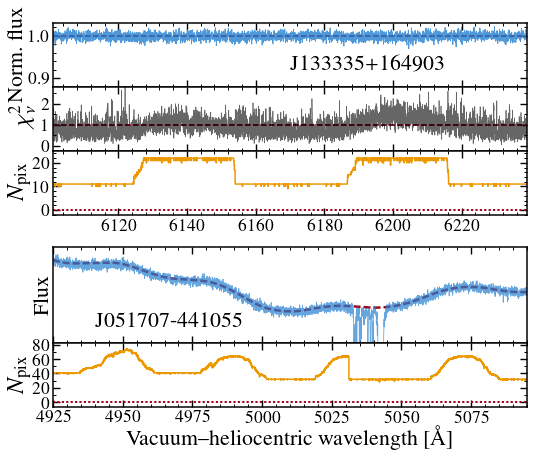

In [201]:
fig=plt.figure(figsize=(7.0,6.0))

# Good colour matches for the colourblind
myc={'violet':'#6E36BB','blue':'#2480D0','cyan':'#00E6E6','green':'#44AA99',
     'orange':'#EC9800','red':'#A00620','black':'#000000'}

# Use J133335+164903 (number 318) as an example of high S/N spectrum with remaining bends
wlmin1,wlmax1=6101,6239
FITSfile=UVESdir+"/"+dDR1QSOs.Name_Adopt[318]+"/"+dDR1QSOs.Name_Adopt[318]+".fits"
s=rUVESpoplerFITS(FITSfile)
filt1=((s['wl']>=wlmin1) & (s['wl']<=wlmax1))
wl1,nf1,cs1,np1=s['wl'][filt1],s['nf'][filt1],s['cs'][filt1],s['npix'][filt1]
# Use J051707-441055 (number 179) as an example of remnant blaze features
wlmin2,wlmax2=4925,5095
FITSfile=UVESdir+"/"+dDR1QSOs.Name_Adopt[179]+"/"+dDR1QSOs.Name_Adopt[179]+".fits"
s=rUVESpoplerFITS(FITSfile)
filt2=((s['wl']>=wlmin2) & (s['wl']<=wlmax2))
wl2,nf2,co2,cs2,np2=s['wl'][filt2],s['nf'][filt2],s['co'][filt2],s['cs'][filt2],s['npix'][filt2]
f2=nf2*co2

## Top panels: high S/N spectrum with remaining bends
# Flux panel
ax1=plt.subplot2grid((12,1),(0,0),rowspan=2,colspan=1)
xmin,xmax=wlmin1,wlmax1
xrng=xmax-xmin
ymax=1.03
ymin=0.88
yrng=ymax-ymin
ax1.hlines(1.0,xmin,xmax,colors=myc['red'],linestyles='--',linewidths=2.0)
ax1.step(wl1,nf1,where='mid',lw=0.8,color=myc['blue'],alpha=0.8,rasterized=True)
ax1.annotate(r'%s' % dDR1QSOs.Name_Adopt[318],xy=(0.5,0.33),xycoords='axes fraction',color=myc['black'],
             ha='left',va='center',fontsize=bfsize)
ax1.set_ylabel(r'Norm.\ flux',ha='center',va='bottom',fontsize=bfsize)
ax1.axes.get_xaxis().set_ticklabels([])
ax1.xaxis.set_minor_locator(AutoMinorLocator(5))
ax1.yaxis.set_minor_locator(AutoMinorLocator(5))
ax1.set_xlim(xmin,xmax)
ax1.set_ylim(ymin,ymax)
# Chisq. panel
ax2=plt.subplot2grid((12,1),(2,0),rowspan=2,colspan=1)
ymax=2.8
ymin=-0.09*ymax
yrng=ymax-ymin
ax2.hlines(1.0,xmin,xmax,colors=myc['red'],linestyles='--',linewidths=2.0)
ax2.step(wl1,cs1,where='mid',lw=0.7,color=myc['black'],alpha=0.6,rasterized=True)
ax2.set_ylabel(r'$\chi^2_\nu$',ha='center',va='bottom',fontsize=1.1*bfsize)
ax2.axes.get_xaxis().set_ticklabels([])
ax2.xaxis.set_minor_locator(AutoMinorLocator(5))
ax2.yaxis.set_major_locator(MultipleLocator(1))
ax2.yaxis.set_minor_locator(AutoMinorLocator(2))
ax2.set_xlim(xmin,xmax)
ax2.set_ylim(ymin,ymax)
# Npix panel
ax3=plt.subplot2grid((12,1),(4,0),rowspan=2,colspan=1)
ymax=25
ymin=-0.09*ymax
yrng=ymax-ymin
ax3.hlines(0.0,xmin,xmax,colors=myc['red'],linestyles=':',linewidths=2.0)
ax3.step(wl1,np1,where='mid',lw=1.5,color=myc['orange'],alpha=1.0,rasterized=True)
ax3.set_ylabel(r'$N_{\rm pix}$',ha='center',va='bottom',fontsize=1.1*bfsize)
ax3.xaxis.set_minor_locator(AutoMinorLocator(5))
ax3.yaxis.set_major_locator(MultipleLocator(10))
ax3.yaxis.set_minor_locator(AutoMinorLocator(5))
ax3.set_xlim(xmin,xmax)
ax3.set_ylim(ymin,ymax)

## Bottom panels: remnant blaze features
# Flux panel
ax4=plt.subplot2grid((12,1),(7,0),rowspan=3,colspan=1)
xmin,xmax=wlmin2,wlmax2
xrng=xmax-xmin
ymax=1.02*max(co2)
ymin=0.85*ymax
yrng=ymax-ymin
ax4.plot(wl2,co2,lw=2.5,color=myc['red'],ls='--',alpha=1.0,rasterized=True)
ax4.step(wl2,f2,where='mid',lw=0.8,color=myc['blue'],alpha=0.7,rasterized=True)
ax4.annotate(r'%s' % dDR1QSOs.Name_Adopt[179],xy=(0.4,0.23),xycoords='axes fraction',color=myc['black'],
             ha='right',va='center',fontsize=bfsize)
ax4.set_ylabel(r'Flux',ha='center',va='bottom',fontsize=bfsize)
ax4.yaxis.set_ticks([])
ax4.axes.get_xaxis().set_ticklabels([])
ax4.xaxis.set_minor_locator(AutoMinorLocator(5))
ax4.set_xlim(xmin,xmax)
ax4.set_ylim(ymin,ymax)
# Npix panel
ax5=plt.subplot2grid((12,1),(10,0),rowspan=2,colspan=1)
ymax=82
ymin=-0.09*ymax
yrng=ymax-ymin
ax5.hlines(0.0,xmin,xmax,colors=myc['red'],linestyles=':',linewidths=2.0)
ax5.step(wl2,np2,where='mid',lw=1.5,color=myc['orange'],alpha=1.0,rasterized=True)
ax5.set_ylabel(r'$N_{\rm pix}$',ha='center',va='bottom',fontsize=1.1*bfsize)
ax5.set_xlabel(r'Vacuum--heliocentric wavelength [\AA]',ha='center',fontsize=bfsize,labelpad=-1)
ax5.xaxis.set_minor_locator(AutoMinorLocator(5))
ax5.yaxis.set_major_locator(MultipleLocator(20))
ax5.yaxis.set_minor_locator(AutoMinorLocator(2))
ax5.set_xlim(xmin,xmax)
ax5.set_ylim(ymin,ymax)

fig.subplots_adjust(left=0.05,right=0.99,bottom=0.10,top=0.99,wspace=0.1,hspace=0.0)
# Export to PDF
#plt.savefig('DR1_bends.pdf',bbox_inches='tight',pad_inches=0.05)

## Plot an example new DLA

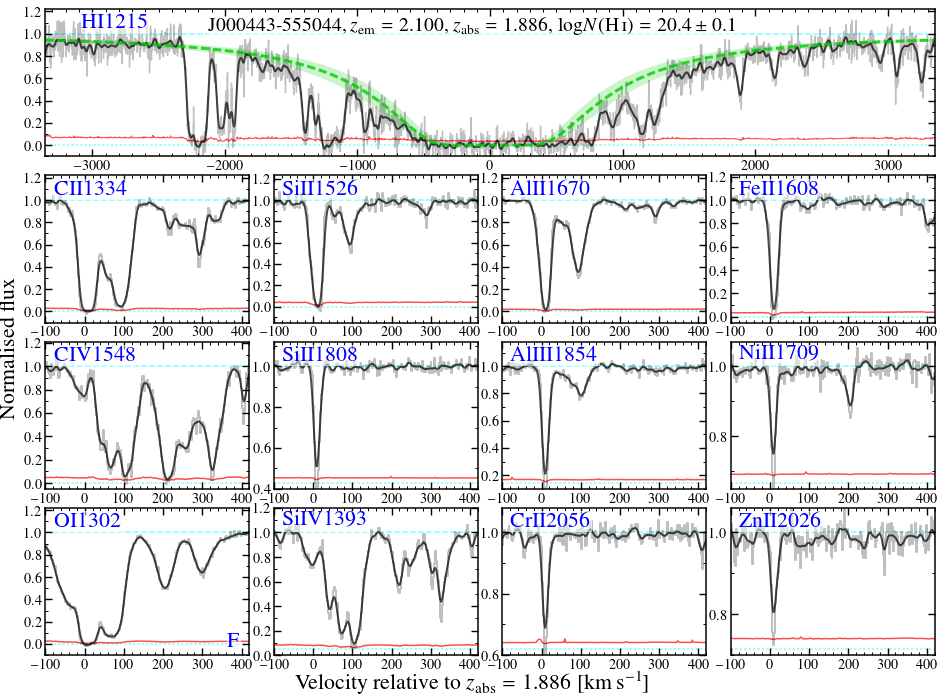

In [7]:
# Read in atomic data file
atdatfile='atom.dat'
atdat=pd.read_csv(atdatfile,delim_whitespace=True)

# Define wl0Lya and c
wl0Lya=1215.6701
c=299792.458

# Find quasars with DLAs found in this work
QSOs_with_newDLAs=dDR1QSOs[dDR1QSOs.DLAReference.str.find("This work")==0]
# Define the particular new DLA to plot
i=QSOs_with_newDLAs.index[0]

# Define transition list
tran=['HI1215',
      'CII1334','CIV1548','OI1302',
      'SiII1526','SiII1808','SiIV1393',
      'AlII1670','AlIII1854','CrII2056',
      'FeII1608','NiII1709','ZnII2026']
ntran=len(tran)

# Extract the DLA information from the database
zabs=[float(z) for z in QSOs_with_newDLAs.DLAzabs[i].split(',')][0]
logNHI=[float(nhi) for nhi in QSOs_with_newDLAs.DLAlogNHI[i].split(',')][0]
elogNHI=[float(enhi) for enhi in QSOs_with_newDLAs.DLAelogNHI[i].split(',')][0]

# Extract main quasar information and spectrum
QSOname=QSOs_with_newDLAs.Name_Adopt[i]
zem=QSOs_with_newDLAs.zem_Adopt[i]
wobsLya=(1+zem)*wl0Lya
FITSfile=UVESdir+"/"+QSOname+"/"+QSOname+".fits"
s=rUVESpoplerFITS(FITSfile)

# Good colour matches for the colourblind
myc={'violet':'#6E36BB','blue':'#2480D0','cyan':'#00E6E6','green':'#44AA99',
     'orange':'#EC9800','red':'#A00620','black':'#000000'}

# Make the velocity plot with Lya on top and metals in rows below
ncols=4
modf=np.modf((ntran-1)/ncols)
nrows=int(modf[1]+1 if modf[0]==0 else modf[1]+2)
ygrain=0.05
fig=plt.figure(figsize=(13.0,ntran*0.75))
ax={}
i=0
for tr in tran:
    # Find transition in atomic data file based on its name
    atom,wlnm=re.split('[IVX]+',tr)
    ion=re.search(r'[IVX]+',tr)[0]
    wllab=atdat.wl[(atdat.atom==atom) & (atdat.ion==ion) & (np.modf(atdat.wl)[1]==float(wlnm))].values      
    wlobs=np.mean(wllab)*(1.0+zabs)
    vbuf=500.0
    if (tr=='HI1215'): vbuf=10000.0
    wls,wle=wlobs*(1.0-vbuf/c),wlobs*(1.0+vbuf/c)
    filt=(s['wl']>=wls) & (s['wl']<=wle)
    wl=s['wl'][filt]
    nf=s['nf'][filt]
    ne=s['ne'][filt]
    ve=c*(wl-wlobs)/wlobs
    if (i==0):
        col,row,colspan,rowspan=0,0,ncols,1
        # Use Barak package to compute Lyman series absorption.
        # Assumpions: b=20.0km/s, vFWHM=6.0km/s
        mod=np.ones([3,len(wl)])
        mod[0],ticks=absorb.calc_DLA_trans(wl,zabs,6.0,logN=logNHI,bHI=20.0)
        mod[1],ticks=absorb.calc_DLA_trans(wl,zabs,6.0,logN=logNHI-elogNHI,bHI=20.0)
        mod[2],ticks=absorb.calc_DLA_trans(wl,zabs,6.0,logN=logNHI+elogNHI,bHI=20.0)
    else:
        colspan,rowspan=1,1
        col=int(np.modf((i-1)/(nrows-1))[1])
        row=int(i-col*(nrows-1))
    ax[tr]=plt.subplot2grid((nrows,ncols),(row,col),rowspan=rowspan,colspan=colspan)
    filtlen=4.0 if i==0 else 2.0
    sm=filters.gaussian_filter1d(nf,filtlen)
    halfwidth=3000+6000.0/(22.0-20.3)*(logNHI-20.3)
    if (i==0): xmin,xmax=-halfwidth,halfwidth
    else: xmin,xmax=-100,420
    xrng=xmax-xmin
    nygrain=np.modf((max(1.0,min(1.1,np.amax(sm)))-max(-0.1,np.amin(sm)))/ygrain)[1]+2.0 if len(sm)>0 else 1.0/ygrain
    ymin=1.0-ygrain*nygrain
    if (i==0): ymin=min(ymin,-0.05)
    ymax=1.0+nygrain*ygrain/5.0
    ymax=max(ymax,1.05)
    yrng=ymax-ymin
    forest=""
    if ((i>0) & (len(wl)>0)):
        if (wl[-1]<=wobsLya): forest="F"
        elif (wl[-1]<=wobsLya*(1.0+5000.0/c)): forest="F?"
    zeroline=max(0.0,ymin+0.04*yrng)
    ax[tr].hlines([zeroline,1.0],xmin,xmax,colors=['#99FFFF','#99FFFF'],linestyles=[':','--'],
                  linewidths=2.0,zorder=1)
    lwmult=1.0 if (i==0) else 1.5
    ax[tr].plot(ve,zeroline+ne,ls='-',lw=1.0*lwmult,color='red',alpha=0.70,rasterized=True)
    ax[tr].step(ve,nf,where='mid',lw=1.33*lwmult,color='black',alpha=0.25,rasterized=True)
    ax[tr].plot(ve,sm,ls='-',lw=2.0,color='black',alpha=0.7,rasterized=True)
    if (i==0):
        ax[tr].plot(ve,mod[0],ls='--',lw=3.0,color='#00CC00',alpha=0.80,rasterized=True)
        ax[tr].fill_between(ve,mod[1],mod[2],facecolor='#00CC00',alpha=0.2,rasterized=True)
    ax[tr].annotate(r'%s' % tr,xy=(0.04,0.91),color='blue',xycoords='axes fraction',ha='left',
                    va='center',fontsize=bfsize,
                    bbox=dict(facecolor='white',alpha=0.5,edgecolor='white',pad=0.5))
    ax[tr].annotate(r'%s' % forest,xy=(0.95,0.09),color='blue',xycoords='axes fraction',ha='right',
                    va='center',fontsize=bfsize,
                    bbox=dict(facecolor='white',alpha=0.5,edgecolor='white',pad=0.5))
    ax[tr].set_xlim(xmin,xmax)
    ax[tr].set_ylim(ymin,ymax)
    xloc=100 if i==0 else 20
    ax[tr].xaxis.set_minor_locator(MultipleLocator(xloc))
    xloc=1000 if i==0 else 100
    ax[tr].xaxis.set_major_locator(MultipleLocator(xloc))
    ax[tr].yaxis.set_minor_locator(MultipleLocator(0.1))
    ax[tr].yaxis.set_major_locator(MultipleLocator(0.2))
    ax[tr].tick_params(labelsize=0.65*bfsize)
    if (i==0):
        ax[tr].annotate(r'%s, $z_{\rm em}=%.3lf$, $z_{\rm abs}=%.3lf$, $\log$$N($H{\sc \,i}$)=%.1lf\pm%.1lf$' %
                        (QSOname,zem,zabs,logNHI,elogNHI),xy=(0.5,0.958),xycoords='figure fraction',
                        ha='center',va='center',fontsize=0.9*bfsize,
                        bbox=dict(facecolor='white',alpha=0.5,edgecolor='white',pad=0.5))
    if ((col==2) & (row==nrows-1)):
        ax[tr].annotate(r'Velocity relative to $z_{\rm abs}=%.3lf$ [km\,s$^{-1}$]' % zabs,
                        xy=(0.5,0.017),xycoords='figure fraction',
                        ha='center',va='center',fontsize=bfsize)
        ax[tr].annotate(r'Normalised flux',xy=(0.02,0.5),xycoords='figure fraction',
                        ha='right',va='center',rotation=90,fontsize=bfsize)
    i+=1

fig.subplots_adjust(left=0.04,right=0.99,bottom=0.05,top=0.97,wspace=0.12,hspace=0.13)
# Export to PDF
#plt.savefig('DR1_J000443_DLA.pdf',bbox_inches='tight',pad_inches=0.05)

## Compare DR1 and SDSS DLA N(HI) distributions, and plot DR1 $z_{\rm abs}$ distribution

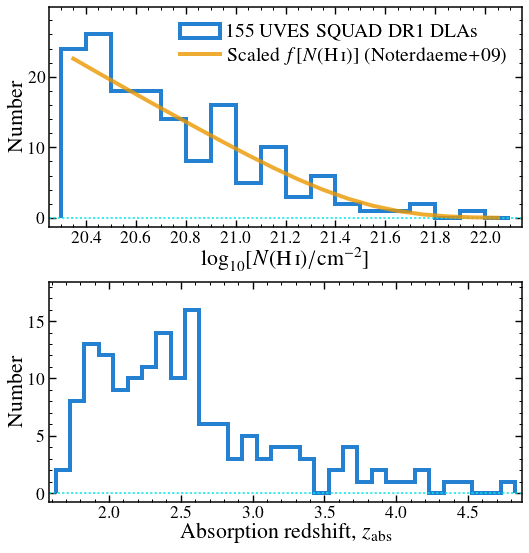

In [22]:
fig=plt.figure(figsize=(7.0,8.0))

# Find quasars with DLAs found in this work
QSOs_with_DLAs=dDR1QSOs[pd.notnull(dDR1QSOs.DLAzabs)]

# Extract flat lists of log column densities and redshifts
z=[QSOs_with_DLAs.DLAzabs[i].split(',') for i in QSOs_with_DLAs.index]
zabs=[float(b) for a in z for b in a]
nDLA=len(zabs)
l=[QSOs_with_DLAs.DLAlogNHI[i].split(',') for i in QSOs_with_DLAs.index]
logNHI=[float(b) for a in l for b in a]

# Good colour matches for the colourblind
myc={'blue':'#2480D0','cyan':'#00E6E6','orange':'#EC9800'}

## Plot logNHI distribution from DR1 spectra and compare to frequency distribution from Noterdaeme et al. (2009)
ax1=plt.subplot2grid((2,1),(0,0),rowspan=1,colspan=1)
# Define xmin, xmax and binning scales
binwid=0.1
xmin,xmax=min(logNHI),max(logNHI)
bins=np.arange(xmin,xmax+1.0*binwid,binwid)
# Fixed parameters for fNHI gamma function from Noterdaeme
kg=np.power(10.0,-22.75)
alphag=-1.27
Nstar=np.power(10.0,21.26)
# Integrate fNHI between logNHI=20.3 and 23.0 (effectively infinity) to normalize to the DR1 sample
fNHIx=np.power(10.0,np.arange(20.2,23.0,0.005))
fNHI=fNHI_Gamma(kg,-1.27,Nstar,fNHIx)
fNHIint=cumtrapz(fNHI[fNHIx>=np.power(10.0,20.3)],fNHIx[fNHIx>=np.power(10.0,20.3)])
fNHInorm=nDLA/fNHIint[-1]
# Determine expected number of DLAs in each bin by integrating between its limits
NDLA=np.zeros(len(bins)-1)
for i in range(0,len(bins)-1):
    filt=(fNHIx>=np.power(10.0,bins[i])) & (fNHIx<np.power(10.0,bins[i+1]))
    NDLA[i]=fNHInorm*cumtrapz(fNHI[filt],fNHIx[filt])[-1]
# Plot the histogram for DR1
n,e,_=ax1.hist(logNHI,bins,align='mid',histtype='step',lw=4.0,ls='-',color=myc['blue'],alpha=1.0,
                label=r'155 UVES SQUAD DR1 DLAs')
# Overlay with normalised Notedaeme et al. distribution
ax1.plot(bins[0:-1]+0.5*binwid,NDLA,ls='-',lw=4.0,color=myc['orange'],alpha=0.8,
        label=r'Scaled $f[N($H{\sc \,i}$)]$ (Noterdaeme+09)')
xmin,xmax=e[0]-0.49*binwid,e[-1]+0.49*binwid
xrng=xmax-xmin
ymax=max(n)
ymin,ymax=-0.05*ymax,1.15*ymax
yrng=ymax-ymin
ax1.hlines([0.0],xmin,xmax,colors=myc['cyan'],linestyles=':',linewidths=1.5)
ax1.set_xlabel(r'$\log_{10} [N($H{\sc \,i}$)/$cm$^{-2}]$',ha='center',fontsize=bfsize,labelpad=5)
ax1.set_ylabel(r'Number',ha='center',va='bottom',fontsize=bfsize)
ax1.set_xlim(xmin,xmax)
ax1.set_ylim(ymin,ymax)
ax1.xaxis.set_major_locator(MultipleLocator(0.2))
ax1.xaxis.set_minor_locator(MultipleLocator(2))
ax1.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.minorticks_on()

# Legend (with order of labels reversed)
handles1,labels1=ax1.get_legend_handles_labels()
leg=ax1.legend(handles1[::-1],labels1[::-1],loc='upper right')

## Plot zabs distribution of DLAs in DR1 spectra
ax2=plt.subplot2grid((2,1),(1,0),rowspan=1,colspan=1)
binwid=0.1
xmin,xmax=min(zabs),max(zabs)
bins=np.arange(xmin,xmax+1.0*binwid,binwid)
n,e,_=ax2.hist(zabs,bins,align='mid',histtype='step',lw=4.0,ls='-',color=myc['blue'],alpha=1.0)
xmin,xmax=e[0]-0.49*binwid,e[-1]+0.49*binwid
xrng=xmax-xmin
ymax=max(n)
ymin,ymax=-0.05*ymax,1.15*ymax
yrng=ymax-ymin
ax2.hlines([0.0],xmin,xmax,colors=myc['cyan'],linestyles=':',linewidths=1.5)
ax2.set_xlabel(r'Absorption redshift, $z_{\rm abs}$',ha='center',fontsize=bfsize,labelpad=5)
ax2.set_ylabel(r'Number',ha='center',va='bottom',fontsize=bfsize)
ax2.set_xlim(xmin,xmax)
ax2.set_ylim(ymin,ymax)
ax2.xaxis.set_minor_locator(MultipleLocator(1))
ax2.yaxis.set_major_locator(MultipleLocator(5))
ax2.yaxis.set_minor_locator(AutoMinorLocator(5))

plt.minorticks_on()
fig.subplots_adjust(left=0.05,right=0.99,bottom=0.13,top=0.99,wspace=0.0,hspace=0.25)
# Export to PDF
#plt.savefig('DR1_DLAdists.pdf',bbox_inches='tight',pad_inches=0.05)

## Example of sub-spectra showing time-variable CIV broad absorption line

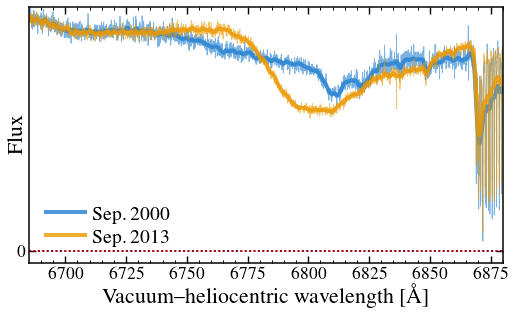

In [41]:
fig=plt.figure(figsize=(7.0,4.0))

# Good colour matches for the colourblind
myc={'violet':'#6E36BB','blue':'#2480D0','cyan':'#00E6E6','green':'#44AA99',
     'orange':'#EC9800','red':'#A00620','black':'#000000'}

# Use J005758-264314 as an example
wlmin,wlmax=6685,6880
FITSfile="J005758-264314_Sep2000.fits"
s=rUVESpoplerFITS(FITSfile)
filt=((s['wl']>=wlmin) & (s['wl']<=wlmax))
wl1,nf1,co1=s['wl'][filt],s['nf'][filt],s['co'][filt]
f1=nf1*co1
FITSfile="J005758-264314_Sep2013.fits"
s=rUVESpoplerFITS(FITSfile)
wl2,nf2,co2=s['wl'][filt],s['nf'][filt],s['co'][filt]
f2=nf2*co2

# Smooth the spectra
filtlen=10.0
sm1=filters.gaussian_filter1d(f1,filtlen)
sm2=filters.gaussian_filter1d(f2,filtlen)

# Plot the spectra
ax1=plt.subplot2grid((1,1),(0,0),rowspan=1,colspan=1)
xmin,xmax=wlmin,wlmax
xrng=xmax-xmin
ymax=1.04*np.amax(co1)
ymin=-0.05*ymax
yrng=ymax-ymin
ax1.hlines(0.0,xmin,xmax,colors=myc['red'],linestyles=':',linewidths=2.0)
ax1.step(wl1,f1,where='mid',lw=0.8,color=myc['blue'],alpha=0.6,rasterized=True)
ax1.plot(wl1,sm1,ls='-',lw=4.0,color=myc['blue'],alpha=0.8,rasterized=True,label=r'Sep.\,2000')
ax1.step(wl2,f2,where='mid',lw=0.8,color=myc['orange'],alpha=0.6,rasterized=True)
ax1.plot(wl2,sm2,ls='-',lw=4.0,color=myc['orange'],alpha=0.8,rasterized=True,label=r'Sep.\,2013')
ax1.set_xlabel(r'Vacuum--heliocentric wavelength [\AA]',ha='center',fontsize=bfsize)
ax1.set_ylabel(r'Flux',ha='center',va='bottom',fontsize=bfsize,labelpad=-10)
ax1.yaxis.set_ticks([0])
ax1.xaxis.set_minor_locator(AutoMinorLocator(5))
ax1.yaxis.set_minor_locator(AutoMinorLocator(5))
ax1.set_xlim(xmin,xmax)
ax1.set_ylim(ymin,ymax)

# Legend 
handles1,labels1=ax1.get_legend_handles_labels()
leg=ax1.legend(handles1,labels1,loc='lower left')

fig.subplots_adjust(left=0.05,right=0.99,bottom=0.10,top=0.99,wspace=0.0,hspace=0.0)
# Export to PDF
#plt.savefig('DR1_broadCIV.pdf',bbox_inches='tight',pad_inches=0.05)